In [226]:
import pyspark, re, json, os
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql.functions import udf, col, regexp_replace, lower, explode, array_contains, collect_set, lit, coalesce, array, count, when, isnull, mean, rand
from pyspark.sql.types import IntegerType, StringType, FloatType, StructType, StructField
from pyspark.ml.feature import StringIndexer
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

In [227]:
# Initialize Spark session
spark = (
    SparkSession.builder.appName("MAST30034 Project 2")
    .config("spark.sql.repl.eagerEval.enabled", True)
    .config("spark.sql.parquet.cacheMetadata", "true")
    .config("spark.sql.session.timeZone", "Etc/UTC")
    .getOrCreate()
)

In [228]:
# Load the data from the JSON file
with open('../data/landing/domain_data.json', 'r') as f:
    data = json.load(f)

# Convert the JSON to a pandas DataFrame
df = pd.DataFrame.from_dict(data, orient='index')

df

,name,cost_text,rooms,parking,description,prop_type,additional_features
https://www.domain.com.au/1001-39-queen-street-melbourne-vic-3000-17221118,"1001/39 Queen Street, Melbourne VIC 3000",$825 per week,"[3 Beds, 1 Bath]",[− Parking],This stunning residence in the historic Madiso...,Apartment / Unit / Flat,NaN
https://www.domain.com.au/2817s-220-spencer-street-melbourne-vic-3000-17223080,"2817s/220 Spencer Street, Melbourne VIC 3000",$800 per week,"[2 Beds, 2 Baths]",[1 Parking],"Stunning Furnished Two Bedroom, Two Bathroom a...",Apartment / Unit / Flat,[Furnished]
https://www.domain.com.au/3207-80-a-beckett-street-melbourne-vic-3000-17119770,"3207/80 A'Beckett Street, Melbourne VIC 3000",$760/w FURNISHED,"[2 Beds, 1 Bath]",[− Parking],The MY80 development gives you the best that t...,Apartment / Unit / Flat,"[Gym, Intercom, Built in wardrobes, Dishwasher..."
https://www.domain.com.au/1413-199-william-street-melbourne-vic-3000-17225646,"1413/199 William Street, Melbourne VIC 3000",$650,"[2 Beds, 1 Bath]",[− Parking],Excellent FULLY FURNISHED property not to miss...,Apartment / Unit / Flat,"[Balcony, Outdoor Entertainment Area, Swimming..."
https://www.domain.com.au/2505-371-little-lonsdale-street-melbourne-vic-3000-17224306,"2505/371 Little Lonsdale Street, Melbourne VIC...",$550,"[1 Bed, 1 Bath]",[− Parking],"380 Melbourne elevates style, convenience, and...",Apartment / Unit / Flat,NaN
...,...,...,...,...,...,...,...
https://www.domain.com.au/19-grazing-road-weir-views-vic-3338-17214974,"19 Grazing Road, Weir Views VIC 3338",$460 per week,"[3 Beds, 2 Baths]",[2 Parking],Spacious 3-bedroom open plan living home offer...,House,[Ensuite]
https://www.domain.com.au/9-norwood-avenue-weir-views-vic-3338-17111843,"9 Norwood Avenue, Weir Views VIC 3338",$460/week,"[4 Beds, 2 Baths]",[2 Parking],A perfect blend of comfort and modern living. ...,House,[]
https://www.domain.com.au/16-shackell-st-weir-views-vic-3338-17222155,"16 Shackell St, Weir Views VIC 3338",$460 weekly,"[4 Beds, 2 Baths]",[2 Parking],"Welcome to your new home at 16 Shackell St, We...",House,[]
https://www.domain.com.au/34-metroon-drive-weir-views-vic-3338-17204576,"34 Metroon Drive, Weir Views VIC 3338",$450,"[3 Beds, 2 Baths]",[2 Parking],The Roof Real Estate is proudly showcasing thi...,House,NaN


In [229]:
df_reset = df.reset_index().rename(columns={'index': 'property_url'})
df_reset

,property_url,name,cost_text,rooms,parking,description,prop_type,additional_features
0,https://www.domain.com.au/1001-39-queen-street...,"1001/39 Queen Street, Melbourne VIC 3000",$825 per week,"[3 Beds, 1 Bath]",[− Parking],This stunning residence in the historic Madiso...,Apartment / Unit / Flat,NaN
1,https://www.domain.com.au/2817s-220-spencer-st...,"2817s/220 Spencer Street, Melbourne VIC 3000",$800 per week,"[2 Beds, 2 Baths]",[1 Parking],"Stunning Furnished Two Bedroom, Two Bathroom a...",Apartment / Unit / Flat,[Furnished]
2,https://www.domain.com.au/3207-80-a-beckett-st...,"3207/80 A'Beckett Street, Melbourne VIC 3000",$760/w FURNISHED,"[2 Beds, 1 Bath]",[− Parking],The MY80 development gives you the best that t...,Apartment / Unit / Flat,"[Gym, Intercom, Built in wardrobes, Dishwasher..."
3,https://www.domain.com.au/1413-199-william-str...,"1413/199 William Street, Melbourne VIC 3000",$650,"[2 Beds, 1 Bath]",[− Parking],Excellent FULLY FURNISHED property not to miss...,Apartment / Unit / Flat,"[Balcony, Outdoor Entertainment Area, Swimming..."
4,https://www.domain.com.au/2505-371-little-lons...,"2505/371 Little Lonsdale Street, Melbourne VIC...",$550,"[1 Bed, 1 Bath]",[− Parking],"380 Melbourne elevates style, convenience, and...",Apartment / Unit / Flat,NaN
...,...,...,...,...,...,...,...,...
11726,https://www.domain.com.au/19-grazing-road-weir...,"19 Grazing Road, Weir Views VIC 3338",$460 per week,"[3 Beds, 2 Baths]",[2 Parking],Spacious 3-bedroom open plan living home offer...,House,[Ensuite]
11727,https://www.domain.com.au/9-norwood-avenue-wei...,"9 Norwood Avenue, Weir Views VIC 3338",$460/week,"[4 Beds, 2 Baths]",[2 Parking],A perfect blend of comfort and modern living. ...,House,[]
11728,https://www.domain.com.au/16-shackell-st-weir-...,"16 Shackell St, Weir Views VIC 3338",$460 weekly,"[4 Beds, 2 Baths]",[2 Parking],"Welcome to your new home at 16 Shackell St, We...",House,[]
11729,https://www.domain.com.au/34-metroon-drive-wei...,"34 Metroon Drive, Weir Views VIC 3338",$450,"[3 Beds, 2 Baths]",[2 Parking],The Roof Real Estate is proudly showcasing thi...,House,NaN


In [230]:
df_reset.to_parquet('../data/raw/domain_data_with_id.parquet', index=False)

In [231]:
sdf = spark.read.parquet('../data/raw/domain_data_with_id.parquet')
sdf.limit(15)

property_url,name,cost_text,rooms,parking,description,prop_type,additional_features
https://www.domai...,1001/39 Queen Str...,$825 per week,"[3 Beds, 1 Bath]",[− Parking],This stunning res...,Apartment / Unit ...,NULL
https://www.domai...,2817s/220 Spencer...,$800 per week,"[2 Beds, 2 Baths]",[1 Parking],Stunning Furnishe...,Apartment / Unit ...,[Furnished]
https://www.domai...,3207/80 A'Beckett...,$760/w FURNISHED,"[2 Beds, 1 Bath]",[− Parking],The MY80 developm...,Apartment / Unit ...,"[Gym, Intercom, B..."
https://www.domai...,1413/199 William ...,$650,"[2 Beds, 1 Bath]",[− Parking],Excellent FULLY F...,Apartment / Unit ...,"[Balcony, Outdoor..."
https://www.domai...,2505/371 Little L...,$550,"[1 Bed, 1 Bath]",[− Parking],380 Melbourne ele...,Apartment / Unit ...,NULL
https://www.domai...,1910/22 - 24 Jane...,$525.00 pw,"[1 Bed, 1 Bath]",[1 Parking],This unfurnished ...,Apartment / Unit ...,[Air conditioning...
https://www.domai...,208/547 Flinders ...,$525 weekly,"[2 Beds, 1 Bath]",[− Parking],***TO BOOK A TIME...,Apartment / Unit ...,NULL
https://www.domai...,303/18-20 Bank Pl...,$525 per week,"[1 Bed, 1 Bath]",[− Parking],HOW DO I REGISTER...,Apartment / Unit ...,[Built in wardrob...
https://www.domai...,2704/288 Spencer ...,$480 per week,"[1 Bed, 1 Bath]",[− Parking],**Booking an insp...,Apartment / Unit ...,"[Gym, Built in wa..."
https://www.domai...,819/555 Flinders ...,$525 per week NOT...,"[1 Bed, 1 Bath]",[1 Parking],Perched high on t...,Apartment / Unit ...,"[Ducted Cooling, ..."


In [232]:
sdf.printSchema()

root
 |-- property_url: string (nullable = true)
 |-- name: string (nullable = true)
 |-- cost_text: string (nullable = true)
 |-- rooms: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- parking: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- description: string (nullable = true)
 |-- prop_type: string (nullable = true)
 |-- additional_features: array (nullable = true)
 |    |-- element: string (containsNull = true)



In [233]:
string_columns = ['property_url', 'name', 'cost_text', 'description', 'prop_type']
for column in string_columns:
    sdf = sdf.withColumn(column, lower(col(column)))

sdf

property_url,name,cost_text,rooms,parking,description,prop_type,additional_features
https://www.domai...,1001/39 queen str...,$825 per week,"[3 Beds, 1 Bath]",[− Parking],this stunning res...,apartment / unit ...,NULL
https://www.domai...,2817s/220 spencer...,$800 per week,"[2 Beds, 2 Baths]",[1 Parking],stunning furnishe...,apartment / unit ...,[Furnished]
https://www.domai...,3207/80 a'beckett...,$760/w furnished,"[2 Beds, 1 Bath]",[− Parking],the my80 developm...,apartment / unit ...,"[Gym, Intercom, B..."
https://www.domai...,1413/199 william ...,$650,"[2 Beds, 1 Bath]",[− Parking],excellent fully f...,apartment / unit ...,"[Balcony, Outdoor..."
https://www.domai...,2505/371 little l...,$550,"[1 Bed, 1 Bath]",[− Parking],380 melbourne ele...,apartment / unit ...,NULL
https://www.domai...,1910/22 - 24 jane...,$525.00 pw,"[1 Bed, 1 Bath]",[1 Parking],this unfurnished ...,apartment / unit ...,[Air conditioning...
https://www.domai...,208/547 flinders ...,$525 weekly,"[2 Beds, 1 Bath]",[− Parking],***to book a time...,apartment / unit ...,NULL
https://www.domai...,303/18-20 bank pl...,$525 per week,"[1 Bed, 1 Bath]",[− Parking],how do i register...,apartment / unit ...,[Built in wardrob...
https://www.domai...,2704/288 spencer ...,$480 per week,"[1 Bed, 1 Bath]",[− Parking],**booking an insp...,apartment / unit ...,"[Gym, Built in wa..."
https://www.domai...,819/555 flinders ...,$525 per week not...,"[1 Bed, 1 Bath]",[1 Parking],perched high on t...,apartment / unit ...,"[Ducted Cooling, ..."


In [234]:
sdf.write.parquet("../data/raw/domain_data", mode="overwrite")

In [235]:
duplicates = sdf.groupBy("name", "description").agg(count("property_url").alias("count")).filter(col("count") > 1)

# Join with the original DataFrame to filter out duplicates
sdf = sdf.join(duplicates, on=["name", "description"], how="left_anti")

# Show the DataFrame without duplicates
sdf.count()

11503

In [236]:
# Define a UDF to extract number of beds
def extract_beds(rooms):
    for room in rooms:
        if 'Bed' in room:
            # Extract the number before the word 'Bed'
            match = re.search(r'(\d+)\s*Beds?', room)
            if match:
                return int(match.group(1))
    return None  # Return None if no beds information is found

# Define a UDF to extract number of baths
def extract_baths(rooms):
    for room in rooms:
        if 'Bath' in room:
            # Extract the number before the word 'Bath'
            match = re.search(r'(\d+)\s*Baths?', room)
            if match:
                return int(match.group(1))
    return None  # Return None if no baths information is found

# Register UDFs
extract_beds_udf = udf(extract_beds, IntegerType())
extract_baths_udf = udf(extract_baths, IntegerType())

# Apply UDFs to create new columns
sdf = sdf.withColumn('beds', extract_beds_udf(sdf['rooms']))
sdf = sdf.withColumn('baths', extract_baths_udf(sdf['rooms']))

# Show the DataFrame to verify new columns
sdf

name,description,property_url,cost_text,rooms,parking,prop_type,additional_features,beds,baths
1001/39 queen str...,this stunning res...,https://www.domai...,$825 per week,"[3 Beds, 1 Bath]",[− Parking],apartment / unit ...,NULL,3,1
2817s/220 spencer...,stunning furnishe...,https://www.domai...,$800 per week,"[2 Beds, 2 Baths]",[1 Parking],apartment / unit ...,[Furnished],2,2
3207/80 a'beckett...,the my80 developm...,https://www.domai...,$760/w furnished,"[2 Beds, 1 Bath]",[− Parking],apartment / unit ...,"[Gym, Intercom, B...",2,1
1413/199 william ...,excellent fully f...,https://www.domai...,$650,"[2 Beds, 1 Bath]",[− Parking],apartment / unit ...,"[Balcony, Outdoor...",2,1
2505/371 little l...,380 melbourne ele...,https://www.domai...,$550,"[1 Bed, 1 Bath]",[− Parking],apartment / unit ...,NULL,1,1
1910/22 - 24 jane...,this unfurnished ...,https://www.domai...,$525.00 pw,"[1 Bed, 1 Bath]",[1 Parking],apartment / unit ...,[Air conditioning...,1,1
208/547 flinders ...,***to book a time...,https://www.domai...,$525 weekly,"[2 Beds, 1 Bath]",[− Parking],apartment / unit ...,NULL,2,1
303/18-20 bank pl...,how do i register...,https://www.domai...,$525 per week,"[1 Bed, 1 Bath]",[− Parking],apartment / unit ...,[Built in wardrob...,1,1
2704/288 spencer ...,**booking an insp...,https://www.domai...,$480 per week,"[1 Bed, 1 Bath]",[− Parking],apartment / unit ...,"[Gym, Built in wa...",1,1
819/555 flinders ...,perched high on t...,https://www.domai...,$525 per week not...,"[1 Bed, 1 Bath]",[1 Parking],apartment / unit ...,"[Ducted Cooling, ...",1,1


In [237]:
# Define a UDF to extract number of beds
def extract_parkings(parkings):
    for parking in parkings:
        if 'Parking' in parking:
            # Extract the number before the word 'Bed'
            match = re.search(r'(\d+)\s*Parking?', parking)
            if match:
                return int(match.group(1))
    return None

# Register UDFs
extract_parkings_udf = udf(extract_parkings, IntegerType())

# Apply UDFs to create new columns
sdf = sdf.withColumn('parkings', extract_parkings_udf(sdf['parking']))

# Show the DataFrame to verify new columns
sdf

name,description,property_url,cost_text,rooms,parking,prop_type,additional_features,beds,baths,parkings
1001/39 queen str...,this stunning res...,https://www.domai...,$825 per week,"[3 Beds, 1 Bath]",[− Parking],apartment / unit ...,NULL,3,1,NULL
2817s/220 spencer...,stunning furnishe...,https://www.domai...,$800 per week,"[2 Beds, 2 Baths]",[1 Parking],apartment / unit ...,[Furnished],2,2,1
3207/80 a'beckett...,the my80 developm...,https://www.domai...,$760/w furnished,"[2 Beds, 1 Bath]",[− Parking],apartment / unit ...,"[Gym, Intercom, B...",2,1,NULL
1413/199 william ...,excellent fully f...,https://www.domai...,$650,"[2 Beds, 1 Bath]",[− Parking],apartment / unit ...,"[Balcony, Outdoor...",2,1,NULL
2505/371 little l...,380 melbourne ele...,https://www.domai...,$550,"[1 Bed, 1 Bath]",[− Parking],apartment / unit ...,NULL,1,1,NULL
1910/22 - 24 jane...,this unfurnished ...,https://www.domai...,$525.00 pw,"[1 Bed, 1 Bath]",[1 Parking],apartment / unit ...,[Air conditioning...,1,1,1
208/547 flinders ...,***to book a time...,https://www.domai...,$525 weekly,"[2 Beds, 1 Bath]",[− Parking],apartment / unit ...,NULL,2,1,NULL
303/18-20 bank pl...,how do i register...,https://www.domai...,$525 per week,"[1 Bed, 1 Bath]",[− Parking],apartment / unit ...,[Built in wardrob...,1,1,NULL
2704/288 spencer ...,**booking an insp...,https://www.domai...,$480 per week,"[1 Bed, 1 Bath]",[− Parking],apartment / unit ...,"[Gym, Built in wa...",1,1,NULL
819/555 flinders ...,perched high on t...,https://www.domai...,$525 per week not...,"[1 Bed, 1 Bath]",[1 Parking],apartment / unit ...,"[Ducted Cooling, ...",1,1,1


In [238]:
# Define a UDF to extract numeric cost from 'cost_text'
def extract_numeric_cost(cost_text):
    if cost_text:
        # Remove commas and search for the first sequence of digits
        match = re.search(r'\d+', cost_text.replace(',', ''))
        if match:
            return int(match.group())  # Convert the found digits to an integer
    return None  # Return None if no digits are found

# Register the UDF with IntegerType as the return type
extract_numeric_cost_udf = udf(extract_numeric_cost, IntegerType())

# Apply UDF to create a new column for cost
sdf = sdf.withColumn('cost', extract_numeric_cost_udf(sdf['cost_text']))

# Show the DataFrame to verify the new 'Cost' column
sdf

name,description,property_url,cost_text,rooms,parking,prop_type,additional_features,beds,baths,parkings,cost
1001/39 queen str...,this stunning res...,https://www.domai...,$825 per week,"[3 Beds, 1 Bath]",[− Parking],apartment / unit ...,NULL,3,1,NULL,825
2817s/220 spencer...,stunning furnishe...,https://www.domai...,$800 per week,"[2 Beds, 2 Baths]",[1 Parking],apartment / unit ...,[Furnished],2,2,1,800
3207/80 a'beckett...,the my80 developm...,https://www.domai...,$760/w furnished,"[2 Beds, 1 Bath]",[− Parking],apartment / unit ...,"[Gym, Intercom, B...",2,1,NULL,760
1413/199 william ...,excellent fully f...,https://www.domai...,$650,"[2 Beds, 1 Bath]",[− Parking],apartment / unit ...,"[Balcony, Outdoor...",2,1,NULL,650
2505/371 little l...,380 melbourne ele...,https://www.domai...,$550,"[1 Bed, 1 Bath]",[− Parking],apartment / unit ...,NULL,1,1,NULL,550
1910/22 - 24 jane...,this unfurnished ...,https://www.domai...,$525.00 pw,"[1 Bed, 1 Bath]",[1 Parking],apartment / unit ...,[Air conditioning...,1,1,1,525
208/547 flinders ...,***to book a time...,https://www.domai...,$525 weekly,"[2 Beds, 1 Bath]",[− Parking],apartment / unit ...,NULL,2,1,NULL,525
303/18-20 bank pl...,how do i register...,https://www.domai...,$525 per week,"[1 Bed, 1 Bath]",[− Parking],apartment / unit ...,[Built in wardrob...,1,1,NULL,525
2704/288 spencer ...,**booking an insp...,https://www.domai...,$480 per week,"[1 Bed, 1 Bath]",[− Parking],apartment / unit ...,"[Gym, Built in wa...",1,1,NULL,480
819/555 flinders ...,perched high on t...,https://www.domai...,$525 per week not...,"[1 Bed, 1 Bath]",[1 Parking],apartment / unit ...,"[Ducted Cooling, ...",1,1,1,525


In [239]:
# Define the schema for the UDF's return type
address_schema = StructType([
    StructField("unit_floor", StringType(), True),
    StructField("street", StringType(), True),
    StructField("suburb", StringType(), True),
    StructField("state", StringType(), True),
    StructField("postal_code", StringType(), True)
])

# Define the UDF to handle complex address formats, including 'suburb state postcode'
def extract_address_components(name):
    # Clean double commas first if any
    name = re.sub(r",,", ",", name)

    # Initialize all components as None
    unit_floor, street, suburb, state, postcode = None, None, None, None, None

    # Split the address based on commas
    parts = [part.strip().lower() for part in name.split(',')]

    # Handle cases based on the number of parts found
    if len(parts) >= 1:
        # Check the last part for 'suburb state postcode'
        suburb_state_postcode = parts[-1]
        state_postcode_match = re.search(r'([a-z]{2,3})\s+(\d{4})$', suburb_state_postcode)
        if state_postcode_match:
            state = state_postcode_match.group(1)
            postcode = state_postcode_match.group(2)
            suburb = suburb_state_postcode[:-(len(state + postcode) + 2)].strip() # just added the plus 2 because melb suburb 

        # Check if there is a unit/floor number or a street
        if len(parts) == 1:
            # Only suburb, state, postcode available
            pass
        elif len(parts) == 2:
            # Could be 'street, suburb state postcode'
            street = parts[0]
        elif len(parts) >= 3:
            # Complex structure with unit/floor number
            unit_floor = parts[0]
            street = ', '.join(parts[1:-1])  # Combine middle parts as street

    return (unit_floor, street, suburb, state, postcode)

# Register the UDF with the schema
extract_address_udf = udf(extract_address_components, address_schema)

# Apply the UDF to create new columns for each address component
sdf = sdf.withColumn("AddressComponents", extract_address_udf(sdf['name']))
sdf = sdf.select(*sdf.columns, "AddressComponents.*")

In [240]:
columns_to_drop = ['AddressComponents']

# Dropping the columns from the DataFrame
sdf = sdf.drop(*columns_to_drop)
sdf

name,description,property_url,cost_text,rooms,parking,prop_type,additional_features,beds,baths,parkings,cost,unit_floor,street,suburb,state,postal_code
1001/39 queen str...,this stunning res...,https://www.domai...,$825 per week,"[3 Beds, 1 Bath]",[− Parking],apartment / unit ...,NULL,3,1,NULL,825,NULL,1001/39 queen street,melbourne,vic,3000
2817s/220 spencer...,stunning furnishe...,https://www.domai...,$800 per week,"[2 Beds, 2 Baths]",[1 Parking],apartment / unit ...,[Furnished],2,2,1,800,NULL,2817s/220 spencer...,melbourne,vic,3000
3207/80 a'beckett...,the my80 developm...,https://www.domai...,$760/w furnished,"[2 Beds, 1 Bath]",[− Parking],apartment / unit ...,"[Gym, Intercom, B...",2,1,NULL,760,NULL,3207/80 a'beckett...,melbourne,vic,3000
1413/199 william ...,excellent fully f...,https://www.domai...,$650,"[2 Beds, 1 Bath]",[− Parking],apartment / unit ...,"[Balcony, Outdoor...",2,1,NULL,650,NULL,1413/199 william ...,melbourne,vic,3000
2505/371 little l...,380 melbourne ele...,https://www.domai...,$550,"[1 Bed, 1 Bath]",[− Parking],apartment / unit ...,NULL,1,1,NULL,550,NULL,2505/371 little l...,melbourne,vic,3000
1910/22 - 24 jane...,this unfurnished ...,https://www.domai...,$525.00 pw,"[1 Bed, 1 Bath]",[1 Parking],apartment / unit ...,[Air conditioning...,1,1,1,525,NULL,1910/22 - 24 jane...,melbourne,vic,3000
208/547 flinders ...,***to book a time...,https://www.domai...,$525 weekly,"[2 Beds, 1 Bath]",[− Parking],apartment / unit ...,NULL,2,1,NULL,525,NULL,208/547 flinders ...,melbourne,vic,3000
303/18-20 bank pl...,how do i register...,https://www.domai...,$525 per week,"[1 Bed, 1 Bath]",[− Parking],apartment / unit ...,[Built in wardrob...,1,1,NULL,525,NULL,303/18-20 bank place,melbourne,vic,3000
2704/288 spencer ...,**booking an insp...,https://www.domai...,$480 per week,"[1 Bed, 1 Bath]",[− Parking],apartment / unit ...,"[Gym, Built in wa...",1,1,NULL,480,NULL,2704/288 spencer ...,melbourne,vic,3000
819/555 flinders ...,perched high on t...,https://www.domai...,$525 per week not...,"[1 Bed, 1 Bath]",[1 Parking],apartment / unit ...,"[Ducted Cooling, ...",1,1,1,525,NULL,819/555 flinders ...,melbourne,vic,3000


In [241]:
sdf = sdf.filter(~col("cost_text").rlike("^[^0-9]*$"))

In [242]:
sdf = sdf.filter(~
    (((col("description").contains("car space")) & 
    ((col("beds") == 0) | (col("baths") == 0)) &
    (col("cost") < 100)) | (col("prop_type") == "carspace"))
)
sdf.show(truncate=False)

+---------------------------------------------------+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-------------------------------------------------------------------------------------+-----------------------------+-----------------+-----------+-----------------------+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+----+-----+--------+----+----------+-------------------------------+---------+-----+-----------

In [243]:
sdf = sdf.withColumn("additional_features", coalesce(col("additional_features"), array()))

In [244]:
sdf.filter(col("cost") > 3000).show(truncate=False)

+-----------------------------------------------+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+---------------------------------------------------------------------------------+--------------------------------------------------+------------------+-----------+-----------------------+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+----+-----+--------+-----+----------+---------------------------+--------------+-----+-----------+
|name                             

In [245]:
#Just a check for the the suburb names

unique_suburbs = sdf.select("suburb").distinct().collect()

for row in unique_suburbs:
    print(row['suburb'])

cremorne
carnegie
mordialloc
mambourin
hurstbridge
noble park north
gladstone st south melbourne
gladstone park
balaclava
cranbourne west
warrandyte
box hill north
frankston north
mornington
keilor
hastings
briar hill
manton road clayton
north warrandyte
kooyong
williams landing
box hill
seaholme
pascoe vale
jacana
meadow heights
croydon
seaford
wyndham vale
craigieburn
richmond
williamstown north
st kilda
bentleigh
middle park
skye
berwick
burnside heights
mitcham
knoxfield
narre warren
lynbrook
south morang
parkville
burwood
bentleigh east
travancore
croydon south
essendon north
east melbourne
rosanna
patterson lakes
cranbourne south
brunswick
preston
johnson st balnarring
south melbourne
toorak
malvern
dandenong north
vermont south
glen huntly
spotswood
caroline springs
mill park
mooroolbark
moorabbin
deepdene
templestowe lower
upper ferntree gully
gowanbrae
nunawading
devon meadows
melbourne
sydenham
derrimut
flinders
prahran
highett
gembrook
boronia
west footscray
bayswater
oaklei

In [246]:
DIMENSION = 25

In [247]:
# Explode the additional_features array to work with each feature separately
features_df = sdf.withColumn("feature", explode(col("additional_features")))

# Count the occurrences of each feature and get the top 20
unique_features_df = features_df.groupBy("feature").count().orderBy(col("count").desc()).limit(DIMENSION)

# Collect the names of the top 20 features
unique_features = [row['feature'] for row in unique_features_df.collect()]

In [248]:
# Add each unique feature as a column to the original DataFrame
for feature in unique_features:
    sdf = sdf.withColumn(feature, array_contains(col("additional_features"), feature).cast("integer"))

# Optionally, show the DataFrame with new one-hot encoded columns
sdf.show(truncate=False)

# Drop the exploded features DataFrame if no longer needed
features_df.unpersist()

+---------------------------------------------------+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-------------------------------------------------------------------------------------+-----------------------------+-----------------+-----------+-----------------------+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+----+-----+--------+----+----------+-------------------------------+---------+-----+-----------

name,description,property_url,cost_text,rooms,parking,prop_type,additional_features,beds,baths,parkings,cost,unit_floor,street,suburb,state,postal_code,feature
2817s/220 spencer...,stunning furnishe...,https://www.domai...,$800 per week,"[2 Beds, 2 Baths]",[1 Parking],apartment / unit ...,[Furnished],2,2,1,800,NULL,2817s/220 spencer...,melbourne,vic,3000,Furnished
3207/80 a'beckett...,the my80 developm...,https://www.domai...,$760/w furnished,"[2 Beds, 1 Bath]",[− Parking],apartment / unit ...,"[Gym, Intercom, B...",2,1,NULL,760,NULL,3207/80 a'beckett...,melbourne,vic,3000,Gym
3207/80 a'beckett...,the my80 developm...,https://www.domai...,$760/w furnished,"[2 Beds, 1 Bath]",[− Parking],apartment / unit ...,"[Gym, Intercom, B...",2,1,NULL,760,NULL,3207/80 a'beckett...,melbourne,vic,3000,Intercom
3207/80 a'beckett...,the my80 developm...,https://www.domai...,$760/w furnished,"[2 Beds, 1 Bath]",[− Parking],apartment / unit ...,"[Gym, Intercom, B...",2,1,NULL,760,NULL,3207/80 a'beckett...,melbourne,vic,3000,Built in wardrobes
3207/80 a'beckett...,the my80 developm...,https://www.domai...,$760/w furnished,"[2 Beds, 1 Bath]",[− Parking],apartment / unit ...,"[Gym, Intercom, B...",2,1,NULL,760,NULL,3207/80 a'beckett...,melbourne,vic,3000,Dishwasher
3207/80 a'beckett...,the my80 developm...,https://www.domai...,$760/w furnished,"[2 Beds, 1 Bath]",[− Parking],apartment / unit ...,"[Gym, Intercom, B...",2,1,NULL,760,NULL,3207/80 a'beckett...,melbourne,vic,3000,Split System Heating
3207/80 a'beckett...,the my80 developm...,https://www.domai...,$760/w furnished,"[2 Beds, 1 Bath]",[− Parking],apartment / unit ...,"[Gym, Intercom, B...",2,1,NULL,760,NULL,3207/80 a'beckett...,melbourne,vic,3000,Split System Air ...
3207/80 a'beckett...,the my80 developm...,https://www.domai...,$760/w furnished,"[2 Beds, 1 Bath]",[− Parking],apartment / unit ...,"[Gym, Intercom, B...",2,1,NULL,760,NULL,3207/80 a'beckett...,melbourne,vic,3000,Outdoor Entertain...
3207/80 a'beckett...,the my80 developm...,https://www.domai...,$760/w furnished,"[2 Beds, 1 Bath]",[− Parking],apartment / unit ...,"[Gym, Intercom, B...",2,1,NULL,760,NULL,3207/80 a'beckett...,melbourne,vic,3000,Balcony
3207/80 a'beckett...,the my80 developm...,https://www.domai...,$760/w furnished,"[2 Beds, 1 Bath]",[− Parking],apartment / unit ...,"[Gym, Intercom, B...",2,1,NULL,760,NULL,3207/80 a'beckett...,melbourne,vic,3000,Swimming Pool


In [249]:
# Function to clean column names
def clean_column_name(column_name):
    # Lowercase all characters
    clean_name = column_name.lower()
    # Replace spaces and special characters with underscores
    clean_name = re.sub(r'\W+', '_', clean_name)
    # Remove leading/trailing underscores that might appear after replacements
    clean_name = re.sub(r'^_|_$', '', clean_name)
    return clean_name

# Get current columns in the DataFrame
current_columns = sdf.columns

# Generate new cleaned column names
new_columns = [clean_column_name(column) for column in current_columns]

# Rename columns in the DataFrame
sdf = sdf.toDF(*new_columns)

# Show the updated DataFrame schema to confirm changes
sdf

name,description,property_url,cost_text,rooms,parking,prop_type,additional_features,beds,baths,parkings,cost,unit_floor,street,suburb,state,postal_code,built_in_wardrobes,dishwasher,air_conditioning,floorboards,secure_parking,intercom,heating,ensuite,balcony_deck,gym,furnished,close_to_shops,close_to_transport,fully_fenced,close_to_schools,ducted_heating,split_system_heating,swimming_pool,remote_garage,balcony,study,garden_courtyard,pets_allowed,internal_laundry,alarm_system
1001/39 queen str...,this stunning res...,https://www.domai...,$825 per week,"[3 Beds, 1 Bath]",[− Parking],apartment / unit ...,[],3,1,NULL,825,NULL,1001/39 queen street,melbourne,vic,3000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2817s/220 spencer...,stunning furnishe...,https://www.domai...,$800 per week,"[2 Beds, 2 Baths]",[1 Parking],apartment / unit ...,[Furnished],2,2,1,800,NULL,2817s/220 spencer...,melbourne,vic,3000,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3207/80 a'beckett...,the my80 developm...,https://www.domai...,$760/w furnished,"[2 Beds, 1 Bath]",[− Parking],apartment / unit ...,"[Gym, Intercom, B...",2,1,NULL,760,NULL,3207/80 a'beckett...,melbourne,vic,3000,1,1,0,0,0,1,0,0,0,1,1,0,0,0,0,0,1,1,0,1,0,0,0,0,0
1413/199 william ...,excellent fully f...,https://www.domai...,$650,"[2 Beds, 1 Bath]",[− Parking],apartment / unit ...,"[Balcony, Outdoor...",2,1,NULL,650,NULL,1413/199 william ...,melbourne,vic,3000,1,1,1,0,0,1,0,0,0,1,1,0,0,0,0,0,0,0,0,1,1,0,0,0,0
2505/371 little l...,380 melbourne ele...,https://www.domai...,$550,"[1 Bed, 1 Bath]",[− Parking],apartment / unit ...,[],1,1,NULL,550,NULL,2505/371 little l...,melbourne,vic,3000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1910/22 - 24 jane...,this unfurnished ...,https://www.domai...,$525.00 pw,"[1 Bed, 1 Bath]",[1 Parking],apartment / unit ...,[Air conditioning...,1,1,1,525,NULL,1910/22 - 24 jane...,melbourne,vic,3000,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
208/547 flinders ...,***to book a time...,https://www.domai...,$525 weekly,"[2 Beds, 1 Bath]",[− Parking],apartment / unit ...,[],2,1,NULL,525,NULL,208/547 flinders ...,melbourne,vic,3000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
303/18-20 bank pl...,how do i register...,https://www.domai...,$525 per week,"[1 Bed, 1 Bath]",[− Parking],apartment / unit ...,[Built in wardrob...,1,1,NULL,525,NULL,303/18-20 bank place,melbourne,vic,3000,1,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0
2704/288 spencer ...,**booking an insp...,https://www.domai...,$480 per week,"[1 Bed, 1 Bath]",[− Parking],apartment / unit ...,"[Gym, Built in wa...",1,1,NULL,480,NULL,2704/288 spencer ...,melbourne,vic,3000,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0
819/555 flinders ...,perched high on t...,https://www.domai...,$525 per week not...,"[1 Bed, 1 Bath]",[1 Parking],apartment / unit ...,"[Ducted Cooling, ...",1,1,1,525,NULL,819/555 flinders ...,melbourne,vic,3000,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0


In [250]:
sdf.select(col("prop_type")).distinct()

prop_type
new house & land
villa
new apartments / ...
apartment / unit ...
block of units
duplex
townhouse
semi-detached
studio
terrace


In [251]:
# Create an instance of StringIndexer
indexer = StringIndexer(inputCol="prop_type", outputCol="prop_type_index")

# Fit the indexer to the DataFrame and transform it
sdf = indexer.fit(sdf).transform(sdf)

# Show the DataFrame with the new numeric 'prop_type_index' column
sdf.select("prop_type", "prop_type_index").show(truncate=False)

+-----------------------+---------------+
|prop_type              |prop_type_index|
+-----------------------+---------------+
|apartment / unit / flat|0.0            |
|apartment / unit / flat|0.0            |
|apartment / unit / flat|0.0            |
|apartment / unit / flat|0.0            |
|apartment / unit / flat|0.0            |
|apartment / unit / flat|0.0            |
|apartment / unit / flat|0.0            |
|apartment / unit / flat|0.0            |
|apartment / unit / flat|0.0            |
|apartment / unit / flat|0.0            |
|apartment / unit / flat|0.0            |
|apartment / unit / flat|0.0            |
|apartment / unit / flat|0.0            |
|apartment / unit / flat|0.0            |
|studio                 |3.0            |
|studio                 |3.0            |
|apartment / unit / flat|0.0            |
|apartment / unit / flat|0.0            |
|apartment / unit / flat|0.0            |
|apartment / unit / flat|0.0            |
+-----------------------+---------

In [252]:
columns_to_drop = ['cost_text', 'rooms', 'parking', 'description', 'prop_type', 'additional_features']

# Dropping the columns from the DataFrame
sdf = sdf.drop(*columns_to_drop)

# Show the updated DataFrame to confirm that columns are dropped
sdf

name,property_url,beds,baths,parkings,cost,unit_floor,street,suburb,state,postal_code,built_in_wardrobes,dishwasher,air_conditioning,floorboards,secure_parking,intercom,heating,ensuite,balcony_deck,gym,furnished,close_to_shops,close_to_transport,fully_fenced,close_to_schools,ducted_heating,split_system_heating,swimming_pool,remote_garage,balcony,study,garden_courtyard,pets_allowed,internal_laundry,alarm_system,prop_type_index
1001/39 queen str...,https://www.domai...,3,1,NULL,825,NULL,1001/39 queen street,melbourne,vic,3000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0
2817s/220 spencer...,https://www.domai...,2,2,1,800,NULL,2817s/220 spencer...,melbourne,vic,3000,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0
3207/80 a'beckett...,https://www.domai...,2,1,NULL,760,NULL,3207/80 a'beckett...,melbourne,vic,3000,1,1,0,0,0,1,0,0,0,1,1,0,0,0,0,0,1,1,0,1,0,0,0,0,0,0.0
1413/199 william ...,https://www.domai...,2,1,NULL,650,NULL,1413/199 william ...,melbourne,vic,3000,1,1,1,0,0,1,0,0,0,1,1,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0.0
2505/371 little l...,https://www.domai...,1,1,NULL,550,NULL,2505/371 little l...,melbourne,vic,3000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0
1910/22 - 24 jane...,https://www.domai...,1,1,1,525,NULL,1910/22 - 24 jane...,melbourne,vic,3000,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0
208/547 flinders ...,https://www.domai...,2,1,NULL,525,NULL,208/547 flinders ...,melbourne,vic,3000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0
303/18-20 bank pl...,https://www.domai...,1,1,NULL,525,NULL,303/18-20 bank place,melbourne,vic,3000,1,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0.0
2704/288 spencer ...,https://www.domai...,1,1,NULL,480,NULL,2704/288 spencer ...,melbourne,vic,3000,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0.0
819/555 flinders ...,https://www.domai...,1,1,1,525,NULL,819/555 flinders ...,melbourne,vic,3000,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0.0


In [253]:
# Write to Parquet
sdf.write.parquet("../data/curated/domain_data.parquet", mode="overwrite")

In [254]:
properties_df = spark.read.csv(
    "../data/raw/properties_stats_final.csv",
    header=True,  # Assumes first row is header
    inferSchema=True  # Infers the input schema automatically from data
)
properties_df

Postcodes,Address,URLS,Latitude,Longitude,Location Type,Count,Location Name,Location Address,Location Latitude,Location Longitude,Travel Time (minutes),Travel Distance (km)
3000,1001/39 Queen Str...,https://www.domai...,-37.8178748,144.9617431,CBD,1,CBD,NULL,-37.8124,144.9623,2.61,1.1
3000,1001/39 Queen Str...,https://www.domai...,-37.8178748,144.9617431,schools,1,Ozford College,"310 King Street, ...",-37.8127971,144.9544042,3.72,1.57
3000,1001/39 Queen Str...,https://www.domai...,-37.8178748,144.9617431,parks,26,Boyd Community Park,"207 City Road, Me...",-37.8255777,144.9612198,3.43,1.19
3000,1001/39 Queen Str...,https://www.domai...,-37.8178748,144.9617431,parks,26,Linear Park,"45 Sturt Street, ...",-37.8250338,144.9672403,4.84,1.74
3000,1001/39 Queen Str...,https://www.domai...,-37.8178748,144.9617431,supermarkets,20,Coles,276 Flinders Stre...,-37.8175611,144.9649673,5.06,1.72
3000,1001/39 Queen Str...,https://www.domai...,-37.8178748,144.9617431,supermarkets,20,IGA X-press + Liquor,46 Whiteman Stree...,-37.825805,144.957017,3.66,1.56
3000,1001/39 Queen Str...,https://www.domai...,-37.8178748,144.9617431,supermarkets,20,IGA,NULL,-37.8164808,144.961159,1.29,0.48
3000,1001/39 Queen Str...,https://www.domai...,-37.8178748,144.9617431,supermarkets,20,Woolworths,NULL,-37.811152,144.965377,3.28,1.42
3000,1001/39 Queen Str...,https://www.domai...,-37.8178748,144.9617431,supermarkets,20,Coles,201 Spencer Stree...,-37.8147983,144.9518038,3.51,1.43
3000,1001/39 Queen Str...,https://www.domai...,-37.8178748,144.9617431,supermarkets,20,Dae Bark Mart,NULL,-37.818584,144.963055,0.86,0.26


In [255]:
# remove the properties amenities with errors
# properties_df = properties_df.filter(
#     (properties_df['Travel Time (minutes)'] != 'Error') & 
#     (properties_df['Travel Distance (km)'] != 'Error')
# )

# properties_df

In [256]:
properties_df.count()

124555

In [257]:
properties_df.select('Address').distinct().count()

11466

In [258]:
properties_df.select("Location Type").distinct()

Location Type
parks
schools
supermarkets
hospitals
shopping_districts
CBD
train_stations


In [259]:
# Grouping by 'URLS' and 'Location Type'
grouped_df = properties_df.groupBy("URLS", "Location Type").agg(
    F.first('Count').alias('Count'),
    F.mean("Travel Time (minutes)").alias("Average Travel Time"),
    F.mean("Travel Distance (km)").alias("Average Travel Distance")
).orderBy("URLS")

grouped_df = grouped_df.withColumn(
    "Time_Distance_Product",
    F.col("Average Travel Time") * F.col("Average Travel Distance")
)

grouped_df

URLS,Location Type,Count,Average Travel Time,Average Travel Distance,Time_Distance_Product
https://www.domai...,CBD,1,10.2,4.95,50.489999999999995
https://www.domai...,schools,7,2.4285714285714284,0.927142857142857,2.251632653061224
https://www.domai...,shopping_districts,4,1.9666666666666668,0.6566666666666667,1.2914444444444446
https://www.domai...,supermarkets,8,3.0537500000000004,0.9024999999999999,2.756009375
https://www.domai...,supermarkets,4,3.2466666666666666,1.6300000000000001,5.292066666666667
https://www.domai...,CBD,1,28.25,17.45,492.9625
https://www.domai...,schools,1,0.5,0.42,0.21
https://www.domai...,schools,4,3.334730215827338,1.5728776978417265,5.245122784793748
https://www.domai...,shopping_districts,1,3.06,1.55,4.743
https://www.domai...,supermarkets,1,4.18,1.69,7.0642


In [260]:
pivot_df = grouped_df.groupBy("URLS").pivot("Location Type", [
    "parks", "schools", "supermarkets", "hospitals", "shopping_districts", "CBD", "train_stations"
]).agg(
    F.first("Count").alias("count"),
    F.first("Average Travel Time").alias("Average Travel Time (Mins)"),
    F.first("Average Travel Distance").alias("Average Travel Distance (Kms)"),
    F.first("Time_Distance_Product").alias("Time_Distance_Product")
)

count_columns = [col for col in pivot_df.columns if col.endswith('_count')]

# Fill null values in the count columns with 0 (since none was found)
pivot_df = pivot_df.fillna(0, subset=count_columns)

# Identify the non-count columns
non_count_columns = [col for col in pivot_df.columns if not col.endswith('_count')]

# Iterate over the non-count columns to replace nulls with the max value
for col_name in non_count_columns:
    # Calculate the maximum value for the column
    max_val = pivot_df.agg(F.max(F.col(col_name)).alias('max_val')).collect()[0]['max_val']
    
    # Replace nulls with the max value in the current column
    if max_val is not None:  # Only proceed if max value is not None
        pivot_df = pivot_df.withColumn(col_name, F.when(F.col(col_name).isNull(), max_val).otherwise(F.col(col_name)))

pivot_df

URLS,parks_count,parks_Average Travel Time (Mins),parks_Average Travel Distance (Kms),parks_Time_Distance_Product,schools_count,schools_Average Travel Time (Mins),schools_Average Travel Distance (Kms),schools_Time_Distance_Product,supermarkets_count,supermarkets_Average Travel Time (Mins),supermarkets_Average Travel Distance (Kms),supermarkets_Time_Distance_Product,hospitals_count,hospitals_Average Travel Time (Mins),hospitals_Average Travel Distance (Kms),hospitals_Time_Distance_Product,shopping_districts_count,shopping_districts_Average Travel Time (Mins),shopping_districts_Average Travel Distance (Kms),shopping_districts_Time_Distance_Product,CBD_count,CBD_Average Travel Time (Mins),CBD_Average Travel Distance (Kms),CBD_Time_Distance_Product,train_stations_count,train_stations_Average Travel Time (Mins),train_stations_Average Travel Distance (Kms),train_stations_Time_Distance_Product
https://www.domai...,0,8.65,2.99,20.8088,7,2.4285714285714284,0.927142857142857,2.251632653061224,8,3.0537500000000004,0.9024999999999999,2.756009375,0,8.31,3.0,22.5201,4,1.9666666666666668,0.6566666666666667,1.2914444444444446,1,10.2,4.95,50.489999999999995,0,7.64,3.0,21.154600000000002
https://www.domai...,0,8.65,2.99,20.8088,1,0.5,0.42,0.21,4,3.2466666666666666,1.6300000000000001,5.292066666666667,0,8.31,3.0,22.5201,0,6.49,2.98,18.618,1,28.25,17.45,492.9625,0,7.64,3.0,21.154600000000002
https://www.domai...,0,8.65,2.99,20.8088,4,3.334730215827338,1.5728776978417265,5.245122784793748,1,4.18,1.69,7.0642,0,8.31,3.0,22.5201,1,3.06,1.55,4.743,1,22.04,14.29,314.9516,0,7.64,3.0,21.154600000000002
https://www.domai...,0,8.65,2.99,20.8088,1,0.5,0.42,0.21,4,3.2466666666666666,1.6300000000000001,5.292066666666667,0,8.31,3.0,22.5201,0,6.49,2.98,18.618,1,28.25,17.45,492.9625,0,7.64,3.0,21.154600000000002
https://www.domai...,0,8.65,2.99,20.8088,1,0.5,0.42,0.21,4,3.2466666666666666,1.6300000000000001,5.292066666666667,0,8.31,3.0,22.5201,0,6.49,2.98,18.618,1,28.25,17.45,492.9625,0,7.64,3.0,21.154600000000002
https://www.domai...,0,8.65,2.99,20.8088,7,2.853333333333333,1.0766666666666664,3.0720888888888878,6,2.8366666666666664,0.9166666666666669,2.600277777777778,9,2.56,0.8971428571428571,2.296685714285714,2,4.27,1.5,6.404999999999999,1,6.06,2.2,13.332,0,7.64,3.0,21.154600000000002
https://www.domai...,0,8.65,2.99,20.8088,4,2.4697302158273384,1.1178776978417264,2.7608563279592153,1,3.3,1.11,3.6630000000000003,0,8.31,3.0,22.5201,1,4.86,2.62,12.733200000000002,1,20.96,13.83,289.8768,0,7.64,3.0,21.154600000000002
https://www.domai...,0,8.65,2.99,20.8088,4,2.7524999999999995,1.2025,3.309881249999999,5,1.702,0.808,1.375216,0,8.31,3.0,22.5201,0,6.49,2.98,18.618,1,26.78,21.43,573.8954,0,7.64,3.0,21.154600000000002
https://www.domai...,0,8.65,2.99,20.8088,5,2.7199999999999998,0.788,2.14336,3,2.9,0.9933333333333333,2.8806666666666665,0,8.31,3.0,22.5201,0,6.49,2.98,18.618,1,18.85,8.54,160.97899999999998,1,3.02,1.06,3.2012
https://www.domai...,0,8.65,2.99,20.8088,3,3.1199999999999997,1.04,3.2447999999999997,3,4.55,1.5066666666666666,6.855333333333332,8,4.056666666666667,1.2466666666666668,5.057311111111112,0,6.49,2.98,18.618,1,29.57,22.98,679.5186,0,7.64,3.0,21.154600000000002


In [261]:
# Join grouped_df with sdf on 'URLS'
joined_df = sdf.join(pivot_df, sdf.property_url == pivot_df.URLS, how="left").drop("URLS")
joined_df

name,property_url,beds,baths,parkings,cost,unit_floor,street,suburb,state,postal_code,built_in_wardrobes,dishwasher,air_conditioning,floorboards,secure_parking,intercom,heating,ensuite,balcony_deck,gym,furnished,close_to_shops,close_to_transport,fully_fenced,close_to_schools,ducted_heating,split_system_heating,swimming_pool,remote_garage,balcony,study,garden_courtyard,pets_allowed,internal_laundry,alarm_system,prop_type_index,parks_count,parks_Average Travel Time (Mins),parks_Average Travel Distance (Kms),parks_Time_Distance_Product,schools_count,schools_Average Travel Time (Mins),schools_Average Travel Distance (Kms),schools_Time_Distance_Product,supermarkets_count,supermarkets_Average Travel Time (Mins),supermarkets_Average Travel Distance (Kms),supermarkets_Time_Distance_Product,hospitals_count,hospitals_Average Travel Time (Mins),hospitals_Average Travel Distance (Kms),hospitals_Time_Distance_Product,shopping_districts_count,shopping_districts_Average Travel Time (Mins),shopping_districts_Average Travel Distance (Kms),shopping_districts_Time_Distance_Product,CBD_count,CBD_Average Travel Time (Mins),CBD_Average Travel Distance (Kms),CBD_Time_Distance_Product,train_stations_count,train_stations_Average Travel Time (Mins),train_stations_Average Travel Distance (Kms),train_stations_Time_Distance_Product
1001/39 queen str...,https://www.domai...,3,1,NULL,825,NULL,1001/39 queen street,melbourne,vic,3000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,26,4.135,1.4649999999999999,6.0577749999999995,1,3.72,1.57,5.840400000000001,20,3.133684210526315,1.2105263157894735,3.793407202216065,0,8.31,3.0,22.5201,10,2.9099999999999997,1.1760000000000002,3.4221600000000003,1,2.61,1.1,2.871,4,4.705,1.73,8.13965
1113/639 lonsdale...,https://www.domai...,2,2,1,800,NULL,1113/639 lonsdale...,melbourne,vic,3000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,17,3.94,1.6866666666666665,6.645466666666666,3,2.4433333333333334,0.9666666666666668,2.361888888888889,17,2.515,1.099375,2.764928125,0,8.31,3.0,22.5201,9,2.934,1.2559999999999998,3.6851039999999995,1,3.29,1.29,4.2441,3,3.57,1.66,5.9262
1114/408 lonsdale...,https://www.domai...,1,1,NULL,400,NULL,1114/408 lonsdale...,melbourne,vic,3000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3.0,0,8.65,2.99,20.8088,4,3.435,1.3875,4.7660625,25,2.137916666666667,0.8941666666666666,1.9116538194444443,0,8.31,3.0,22.5201,12,1.8666666666666665,0.775,1.4466666666666665,1,1.08,0.41,0.4428,4,4.59,2.04,9.3636
1310/555 flinders...,https://www.domai...,2,1,1,850,NULL,1310/555 flinders...,melbourne,vic,3000,0,1,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,1,0,0,0,0,0.0,23,3.6533333333333338,1.5933333333333335,5.820977777777779,2,3.5949999999999998,1.58,5.6800999999999995,17,3.1212500000000003,1.278125,3.98934765625,0,8.31,3.0,22.5201,7,3.728,1.442,5.375776,1,4.42,1.87,8.2654,3,4.69,1.83,8.5827
1413/199 william ...,https://www.domai...,2,1,NULL,650,NULL,1413/199 william ...,melbourne,vic,3000,1,1,1,0,0,1,0,0,0,1,1,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0.0,0,8.65,2.99,20.8088,3,2.44,0.8633333333333333,2.106533333333333,23,2.9154545454545455,1.106818181818182,3.226878099173554,0,8.31,3.0,22.5201,12,2.776666666666667,1.0783333333333334,2.9941722222222227,1,2.46,0.89,2.1894,4,4.99,1.975,9.855250000000002
1503/270 king str...,https://www.domai...,4,1,1,850,NULL,1503/270 king street,melbourne,vic,3000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,17,4.41,1.92,8.4672,4,3.0475,1.1375000000000002,3.4665312500000005,23,2.8254545454545448,1.1722727272727271,3.312203305785123,0,8.31,3.0,22.5201,11,2.8366666666666664,1.1983333333333333,3.399272222222222,1,2.57,1.02,2.6214,4,4.84,2.0999999999999996,10.163999999999998
1910/22 - 24 jane...,https://www.domai...,1,1,1,525,NULL,1910/22 - 24 jane...,melbourne,vic,3000,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0,8.65,2.99,20.8088,3,4.09,1.4166666666666667,5.7941666666666665,21,2.4199999999999995,0.9509523809523808,2.301304761904761,5,3.5075,1.2725,4.46329375,10,2.522,1.028,

In [262]:
# Get current columns in the DataFrame
current_columns = joined_df.columns

# Generate new cleaned column names
new_columns = [clean_column_name(column) for column in current_columns]

# Rename columns in the DataFrame
joined_df = joined_df.toDF(*new_columns)
joined_df

name,property_url,beds,baths,parkings,cost,unit_floor,street,suburb,state,postal_code,built_in_wardrobes,dishwasher,air_conditioning,floorboards,secure_parking,intercom,heating,ensuite,balcony_deck,gym,furnished,close_to_shops,close_to_transport,fully_fenced,close_to_schools,ducted_heating,split_system_heating,swimming_pool,remote_garage,balcony,study,garden_courtyard,pets_allowed,internal_laundry,alarm_system,prop_type_index,parks_count,parks_average_travel_time_mins,parks_average_travel_distance_kms,parks_time_distance_product,schools_count,schools_average_travel_time_mins,schools_average_travel_distance_kms,schools_time_distance_product,supermarkets_count,supermarkets_average_travel_time_mins,supermarkets_average_travel_distance_kms,supermarkets_time_distance_product,hospitals_count,hospitals_average_travel_time_mins,hospitals_average_travel_distance_kms,hospitals_time_distance_product,shopping_districts_count,shopping_districts_average_travel_time_mins,shopping_districts_average_travel_distance_kms,shopping_districts_time_distance_product,cbd_count,cbd_average_travel_time_mins,cbd_average_travel_distance_kms,cbd_time_distance_product,train_stations_count,train_stations_average_travel_time_mins,train_stations_average_travel_distance_kms,train_stations_time_distance_product
1001/39 queen str...,https://www.domai...,3,1,NULL,825,NULL,1001/39 queen street,melbourne,vic,3000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,26,4.135,1.4649999999999999,6.0577749999999995,1,3.72,1.57,5.840400000000001,20,3.133684210526315,1.2105263157894735,3.793407202216065,0,8.31,3.0,22.5201,10,2.9099999999999997,1.1760000000000002,3.4221600000000003,1,2.61,1.1,2.871,4,4.705,1.73,8.13965
1113/639 lonsdale...,https://www.domai...,2,2,1,800,NULL,1113/639 lonsdale...,melbourne,vic,3000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,17,3.94,1.6866666666666665,6.645466666666666,3,2.4433333333333334,0.9666666666666668,2.361888888888889,17,2.515,1.099375,2.764928125,0,8.31,3.0,22.5201,9,2.934,1.2559999999999998,3.6851039999999995,1,3.29,1.29,4.2441,3,3.57,1.66,5.9262
1114/408 lonsdale...,https://www.domai...,1,1,NULL,400,NULL,1114/408 lonsdale...,melbourne,vic,3000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3.0,0,8.65,2.99,20.8088,4,3.435,1.3875,4.7660625,25,2.137916666666667,0.8941666666666666,1.9116538194444443,0,8.31,3.0,22.5201,12,1.8666666666666665,0.775,1.4466666666666665,1,1.08,0.41,0.4428,4,4.59,2.04,9.3636
1310/555 flinders...,https://www.domai...,2,1,1,850,NULL,1310/555 flinders...,melbourne,vic,3000,0,1,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,1,0,0,0,0,0.0,23,3.6533333333333338,1.5933333333333335,5.820977777777779,2,3.5949999999999998,1.58,5.6800999999999995,17,3.1212500000000003,1.278125,3.98934765625,0,8.31,3.0,22.5201,7,3.728,1.442,5.375776,1,4.42,1.87,8.2654,3,4.69,1.83,8.5827
1413/199 william ...,https://www.domai...,2,1,NULL,650,NULL,1413/199 william ...,melbourne,vic,3000,1,1,1,0,0,1,0,0,0,1,1,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0.0,0,8.65,2.99,20.8088,3,2.44,0.8633333333333333,2.106533333333333,23,2.9154545454545455,1.106818181818182,3.226878099173554,0,8.31,3.0,22.5201,12,2.776666666666667,1.0783333333333334,2.9941722222222227,1,2.46,0.89,2.1894,4,4.99,1.975,9.855250000000002
1503/270 king str...,https://www.domai...,4,1,1,850,NULL,1503/270 king street,melbourne,vic,3000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,17,4.41,1.92,8.4672,4,3.0475,1.1375000000000002,3.4665312500000005,23,2.8254545454545448,1.1722727272727271,3.312203305785123,0,8.31,3.0,22.5201,11,2.8366666666666664,1.1983333333333333,3.399272222222222,1,2.57,1.02,2.6214,4,4.84,2.0999999999999996,10.163999999999998
1910/22 - 24 jane...,https://www.domai...,1,1,1,525,NULL,1910/22 - 24 jane...,melbourne,vic,3000,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0,8.65,2.99,20.8088,3,4.09,1.4166666666666667,5.7941666666666665,21,2.4199999999999995,0.9509523809523808,2.301304761904761,5,3.5075,1.2725,4.46329375,10,2.522,1.028,2.592616,1,2.14,0.88,1.88320

In [263]:
historical_df = pd.read_excel("../data/raw/historical.xlsx")
historical_df

,suburb,postcode,2000-03-01 00:00:00,2000-06-01 00:00:00,2000-09-01 00:00:00,2000-12-01 00:00:00,2001-03-01 00:00:00,2001-06-01 00:00:00,2001-09-01 00:00:00,2001-12-01 00:00:00,...,2020-12-01 00:00:00,2021-03-01 00:00:00,2021-06-01 00:00:00,2021-09-01 00:00:00,2021-12-01 00:00:00,2022-03-01 00:00:00,2022-06-01 00:00:00,2022-09-01 00:00:00,2022-12-01 00:00:00,2023-03-01 00:00:00
0,Albert Park-Middle Park-West St Kilda,3206,260,260,270,275,275,280,280,290,...,550,500,500,500,495,500,515,500,525,545
1,Armadale,3143,200,200,205,210,215,220,225,230,...,495,450,440,425,420,430,450,450,460,490
2,Carlton North,3054,260,260,265,270,270,275,280,280,...,590,580,575,575,580,580,595,600,600,620
3,Carlton-Parkville,3053,260,260,260,260,260,260,265,270,...,395,350,340,330,320,310,319,340,350,400
4,CBD-St Kilda Rd,3000,320,320,320,320,320,320,320,320,...,420,380,369,350,350,365,390,419,450,500
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
141,Traralgon,3844,125,120,125,125,125,125,130,125,...,320,330,340,350,360,360,380,380,380,385
142,Wanagaratta,3677,125,125,130,130,130,130,130,135,...,308,320,330,350,360,370,380,380,380,380
143,Warragul,3820,130,135,135,135,135,135,140,140,...,380,375,380,390,390,400,400,420,430,440
144,Warrnambool,3280,130,135,135,135,140,140,140,145,...,350,350,360,370,380,400,400,420,420,420


In [264]:
# Initialize the base columns
new_columns = ['suburb', 'postcode']

# Creating the date range columns for Mar, Jun, Sep, Dec for each year from 2000 to March 2023
years = range(2000, 2024)
months = ['mar', 'jun', 'sep', 'dec']

# Loop over each year and each month to generate the new column names
for year in years:
    for month in months:
        # Only include up to March 2023, break after it
        if year == 2023 and month == 'mar':
            new_columns.append(f'{month}_{year}')
            break
        new_columns.append(f'{month}_{year}')
historical_df.columns = new_columns
new_columns

['suburb',
 'postcode',
 'mar_2000',
 'jun_2000',
 'sep_2000',
 'dec_2000',
 'mar_2001',
 'jun_2001',
 'sep_2001',
 'dec_2001',
 'mar_2002',
 'jun_2002',
 'sep_2002',
 'dec_2002',
 'mar_2003',
 'jun_2003',
 'sep_2003',
 'dec_2003',
 'mar_2004',
 'jun_2004',
 'sep_2004',
 'dec_2004',
 'mar_2005',
 'jun_2005',
 'sep_2005',
 'dec_2005',
 'mar_2006',
 'jun_2006',
 'sep_2006',
 'dec_2006',
 'mar_2007',
 'jun_2007',
 'sep_2007',
 'dec_2007',
 'mar_2008',
 'jun_2008',
 'sep_2008',
 'dec_2008',
 'mar_2009',
 'jun_2009',
 'sep_2009',
 'dec_2009',
 'mar_2010',
 'jun_2010',
 'sep_2010',
 'dec_2010',
 'mar_2011',
 'jun_2011',
 'sep_2011',
 'dec_2011',
 'mar_2012',
 'jun_2012',
 'sep_2012',
 'dec_2012',
 'mar_2013',
 'jun_2013',
 'sep_2013',
 'dec_2013',
 'mar_2014',
 'jun_2014',
 'sep_2014',
 'dec_2014',
 'mar_2015',
 'jun_2015',
 'sep_2015',
 'dec_2015',
 'mar_2016',
 'jun_2016',
 'sep_2016',
 'dec_2016',
 'mar_2017',
 'jun_2017',
 'sep_2017',
 'dec_2017',
 'mar_2018',
 'jun_2018',
 'sep_2018',
 

In [265]:
historical_df.replace('-', np.nan, inplace=True)
historical_df = historical_df.apply(lambda col: col.fillna(col.mean()) if col.dtype in ['float64', 'int64'] else col)
historical_df.iloc[:, 2:] = historical_df.iloc[:, 2:].astype(float)
historical_df

/var/folders/27/hm8cnznd78x3flv3w2sfvqwm0000gp/T/ipykernel_71711/277358179.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  historical_df.replace('-', np.nan, inplace=True)
/var/folders/27/hm8cnznd78x3flv3w2sfvqwm0000gp/T/ipykernel_71711/277358179.py:3: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0      260.0
1      200.0
2      260.0
3      260.0
4      320.0
       ...  
141    120.0
142    125.0
143    135.0
144    135.0
145    145.0
Name: jun_2000, Length: 146, dtype: float64' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  historical_df.iloc[:, 2:] = historical_df.iloc[:, 2:].astype(float)
/var/folders/27/hm8cnznd78x3flv3w2sfvqwm0000gp/T

,suburb,postcode,mar_2000,jun_2000,sep_2000,dec_2000,mar_2001,jun_2001,sep_2001,dec_2001,...,dec_2020,mar_2021,jun_2021,sep_2021,dec_2021,mar_2022,jun_2022,sep_2022,dec_2022,mar_2023
0,Albert Park-Middle Park-West St Kilda,3206,260.0,260.0,270.0,275.0,275.0,280.0,280.0,290.0,...,550.0,500.0,500.0,500.0,495.0,500.0,515.0,500.0,525.0,545.0
1,Armadale,3143,200.0,200.0,205.0,210.0,215.0,220.0,225.0,230.0,...,495.0,450.0,440.0,425.0,420.0,430.0,450.0,450.0,460.0,490.0
2,Carlton North,3054,260.0,260.0,265.0,270.0,270.0,275.0,280.0,280.0,...,590.0,580.0,575.0,575.0,580.0,580.0,595.0,600.0,600.0,620.0
3,Carlton-Parkville,3053,260.0,260.0,260.0,260.0,260.0,260.0,265.0,270.0,...,395.0,350.0,340.0,330.0,320.0,310.0,319.0,340.0,350.0,400.0
4,CBD-St Kilda Rd,3000,320.0,320.0,320.0,320.0,320.0,320.0,320.0,320.0,...,420.0,380.0,369.0,350.0,350.0,365.0,390.0,419.0,450.0,500.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
141,Traralgon,3844,125.0,120.0,125.0,125.0,125.0,125.0,130.0,125.0,...,320.0,330.0,340.0,350.0,360.0,360.0,380.0,380.0,380.0,385.0
142,Wanagaratta,3677,125.0,125.0,130.0,130.0,130.0,130.0,130.0,135.0,...,308.0,320.0,330.0,350.0,360.0,370.0,380.0,380.0,380.0,380.0
143,Warragul,3820,130.0,135.0,135.0,135.0,135.0,135.0,140.0,140.0,...,380.0,375.0,380.0,390.0,390.0,400.0,400.0,420.0,430.0,440.0
144,Warrnambool,3280,130.0,135.0,135.0,135.0,140.0,140.0,140.0,145.0,...,350.0,350.0,360.0,370.0,380.0,400.0,400.0,420.0,420.0,420.0


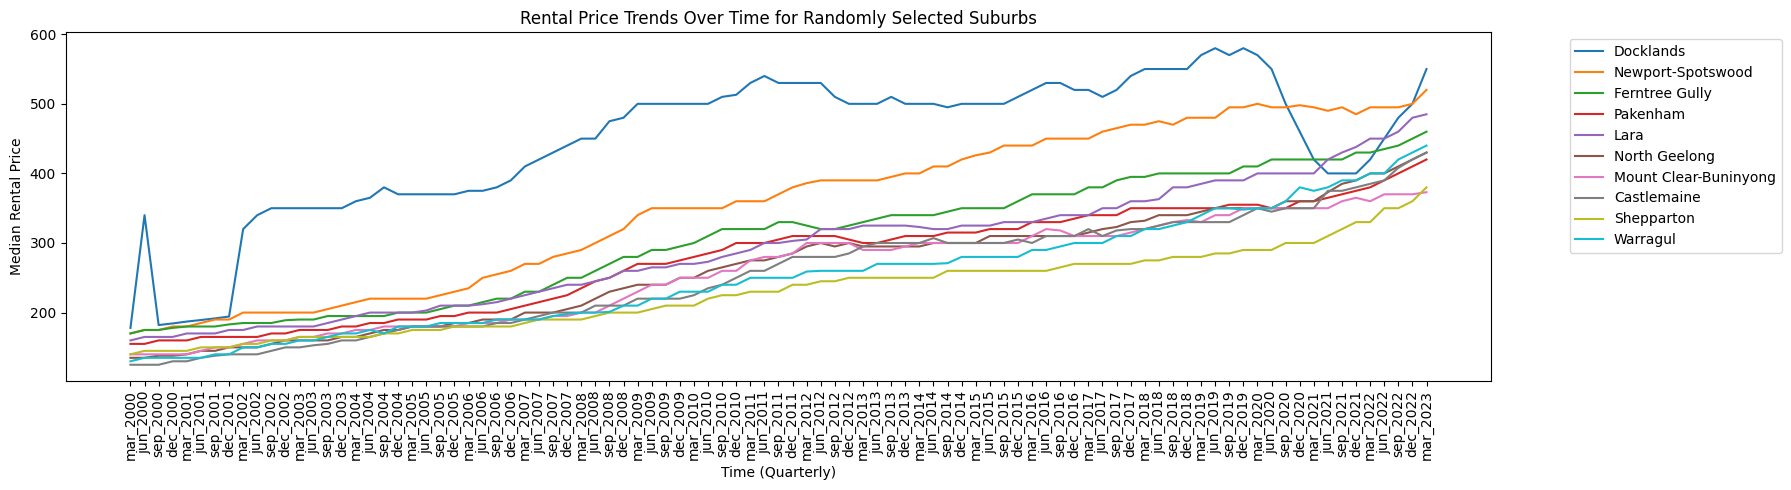

In [266]:
import random
random.seed(1003)
# Randomly select 10 suburbs from the DataFrame
random_suburbs = random.sample(list(historical_df['suburb']), 10)

# Filter the DataFrame for the selected suburbs
selected_suburbs = historical_df[historical_df['suburb'].isin(random_suburbs)]

# Plotting the trends for the randomly selected suburbs
plt.figure(figsize=(18, 5))

for suburb in selected_suburbs['suburb']:
    plt.plot(selected_suburbs.columns[2:], selected_suburbs[selected_suburbs['suburb'] == suburb].values[0][2:], label=suburb)

plt.title('Rental Price Trends Over Time for Randomly Selected Suburbs')
plt.xlabel('Time (Quarterly)')
plt.ylabel('Median Rental Price')
plt.xticks(rotation=90)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')  # Move the legend outside the plot
plt.tight_layout()
plt.show()

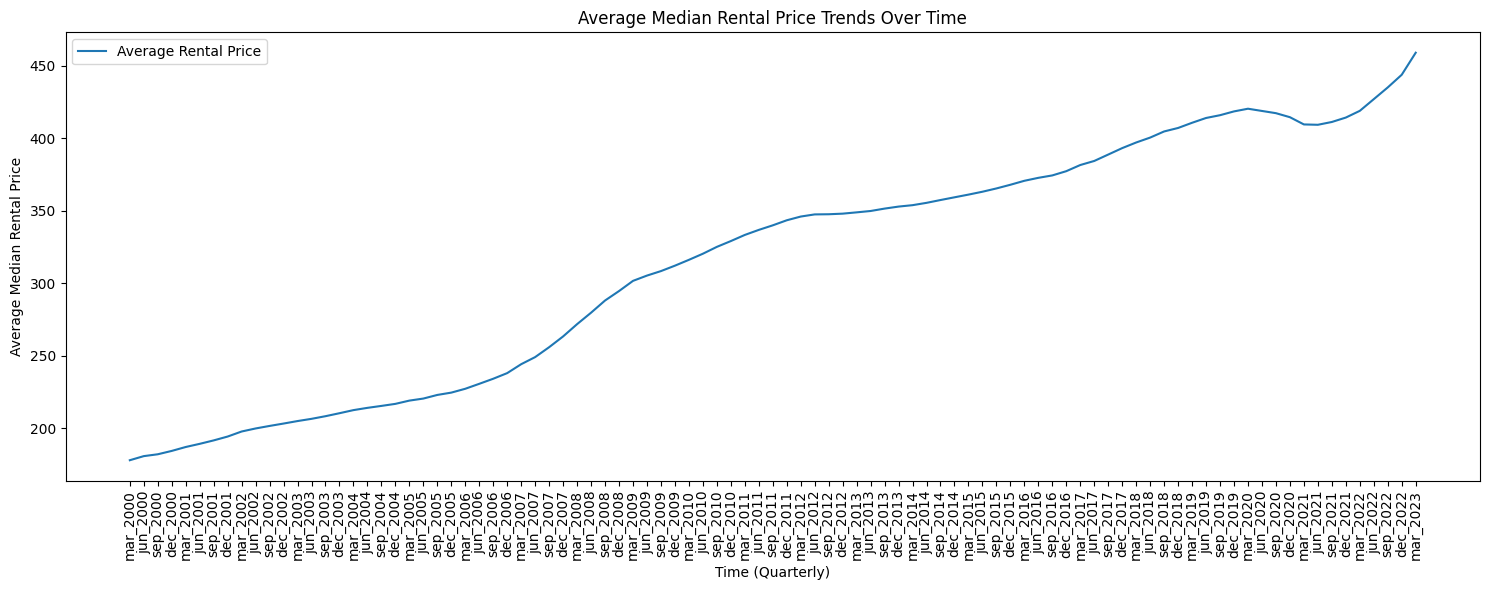

In [267]:
# Calculate the average rental prices for all suburbs over time
average_rental_prices = historical_df.iloc[:, 2:].mean()

# Plotting the average rental price trend over time
plt.figure(figsize=(15, 6))
plt.plot(historical_df.columns[2:], average_rental_prices, label='Average Rental Price')

plt.title('Average Median Rental Price Trends Over Time')
plt.xlabel('Time (Quarterly)')
plt.ylabel('Average Median Rental Price')
plt.xticks(rotation=90)
plt.legend()
plt.tight_layout()
plt.show()

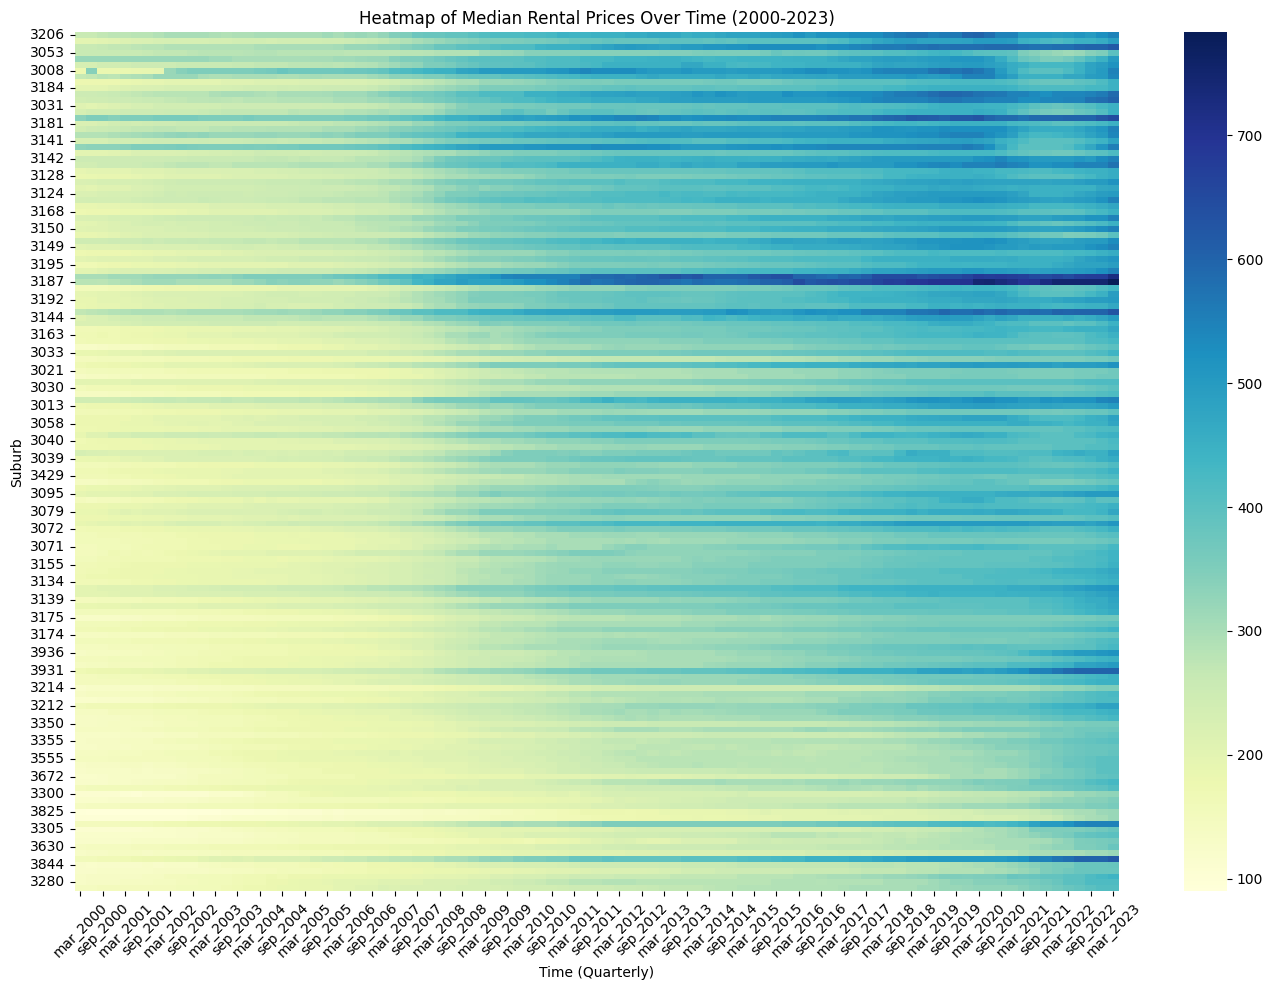

In [268]:
# Create a heatmap for all the suburbs
plt.figure(figsize=(14, 10))

# Exclude the first two columns 'suburb' and 'postcode' for the heatmap
sns.heatmap(historical_df.iloc[:, 2:].set_index(historical_df['postcode']), cmap="YlGnBu", annot=False)

plt.title('Heatmap of Median Rental Prices Over Time (2000-2023)')
plt.xlabel('Time (Quarterly)')
plt.ylabel('Suburb')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [269]:
# Create a new column for 12-month price increase rate
def calculate_12_month_rate(row):
    # Take all the values except the first two columns (suburb and postcode)
    price_values = row[2:].values
    # Calculate the percentage change from the same quarter of the previous year (4 steps apart)
    rate_of_change = [(price_values[i] - price_values[i - 4]) / price_values[i - 4] * 100 if i >= 4 and price_values[i - 4] != 0 else np.nan for i in range(len(price_values))]
    return rate_of_change

# Apply the function row-wise to calculate the price increase rate for each suburb
historical_df['annual_increase'] = historical_df.apply(calculate_12_month_rate, axis=1)

# Display the updated dataframe with the new column
historical_df

,suburb,postcode,mar_2000,jun_2000,sep_2000,dec_2000,mar_2001,jun_2001,sep_2001,dec_2001,...,mar_2021,jun_2021,sep_2021,dec_2021,mar_2022,jun_2022,sep_2022,dec_2022,mar_2023,annual_increase
0,Albert Park-Middle Park-West St Kilda,3206,260.0,260.0,270.0,275.0,275.0,280.0,280.0,290.0,...,500.0,500.0,500.0,495.0,500.0,515.0,500.0,525.0,545.0,"[nan, nan, nan, nan, 5.769230769230769, 7.6923..."
1,Armadale,3143,200.0,200.0,205.0,210.0,215.0,220.0,225.0,230.0,...,450.0,440.0,425.0,420.0,430.0,450.0,450.0,460.0,490.0,"[nan, nan, nan, nan, 7.5, 10.0, 9.756097560975..."
2,Carlton North,3054,260.0,260.0,265.0,270.0,270.0,275.0,280.0,280.0,...,580.0,575.0,575.0,580.0,580.0,595.0,600.0,600.0,620.0,"[nan, nan, nan, nan, 3.8461538461538463, 5.769..."
3,Carlton-Parkville,3053,260.0,260.0,260.0,260.0,260.0,260.0,265.0,270.0,...,350.0,340.0,330.0,320.0,310.0,319.0,340.0,350.0,400.0,"[nan, nan, nan, nan, 0.0, 0.0, 1.9230769230769..."
4,CBD-St Kilda Rd,3000,320.0,320.0,320.0,320.0,320.0,320.0,320.0,320.0,...,380.0,369.0,350.0,350.0,365.0,390.0,419.0,450.0,500.0,"[nan, nan, nan, nan, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
141,Traralgon,3844,125.0,120.0,125.0,125.0,125.0,125.0,130.0,125.0,...,330.0,340.0,350.0,360.0,360.0,380.0,380.0,380.0,385.0,"[nan, nan, nan, nan, 0.0, 4.166666666666666, 4..."
142,Wanagaratta,3677,125.0,125.0,130.0,130.0,130.0,130.0,130.0,135.0,...,320.0,330.0,350.0,360.0,370.0,380.0,380.0,380.0,380.0,"[nan, nan, nan, nan, 4.0, 4.0, 0.0, 3.84615384..."
143,Warragul,3820,130.0,135.0,135.0,135.0,135.0,135.0,140.0,140.0,...,375.0,380.0,390.0,390.0,400.0,400.0,420.0,430.0,440.0,"[nan, nan, nan, nan, 3.8461538461538463, 0.0, ..."
144,Warrnambool,3280,130.0,135.0,135.0,135.0,140.0,140.0,140.0,145.0,...,350.0,360.0,370.0,380.0,400.0,400.0,420.0,420.0,420.0,"[nan, nan, nan, nan, 7.6923076923076925, 3.703..."


In [270]:
historical_df['annual_increase'] = historical_df['annual_increase'].apply(lambda x: np.nanmean(x))
historical_df

,suburb,postcode,mar_2000,jun_2000,sep_2000,dec_2000,mar_2001,jun_2001,sep_2001,dec_2001,...,mar_2021,jun_2021,sep_2021,dec_2021,mar_2022,jun_2022,sep_2022,dec_2022,mar_2023,annual_increase
0,Albert Park-Middle Park-West St Kilda,3206,260.0,260.0,270.0,275.0,275.0,280.0,280.0,290.0,...,500.0,500.0,500.0,495.0,500.0,515.0,500.0,525.0,545.0,3.210066
1,Armadale,3143,200.0,200.0,205.0,210.0,215.0,220.0,225.0,230.0,...,450.0,440.0,425.0,420.0,430.0,450.0,450.0,460.0,490.0,3.925236
2,Carlton North,3054,260.0,260.0,265.0,270.0,270.0,275.0,280.0,280.0,...,580.0,575.0,575.0,580.0,580.0,595.0,600.0,600.0,620.0,3.851826
3,Carlton-Parkville,3053,260.0,260.0,260.0,260.0,260.0,260.0,265.0,270.0,...,350.0,340.0,330.0,320.0,310.0,319.0,340.0,350.0,400.0,1.559761
4,CBD-St Kilda Rd,3000,320.0,320.0,320.0,320.0,320.0,320.0,320.0,320.0,...,380.0,369.0,350.0,350.0,365.0,390.0,419.0,450.0,500.0,1.789150
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
141,Traralgon,3844,125.0,120.0,125.0,125.0,125.0,125.0,130.0,125.0,...,330.0,340.0,350.0,360.0,360.0,380.0,380.0,380.0,385.0,5.266525
142,Wanagaratta,3677,125.0,125.0,130.0,130.0,130.0,130.0,130.0,135.0,...,320.0,330.0,350.0,360.0,370.0,380.0,380.0,380.0,380.0,5.080689
143,Warragul,3820,130.0,135.0,135.0,135.0,135.0,135.0,140.0,140.0,...,375.0,380.0,390.0,390.0,400.0,400.0,420.0,430.0,440.0,5.341622
144,Warrnambool,3280,130.0,135.0,135.0,135.0,140.0,140.0,140.0,145.0,...,350.0,360.0,370.0,380.0,400.0,400.0,420.0,420.0,420.0,5.292409


In [273]:
historical_df.to_csv("../data/curated/historical_rent.csv", index=False)

In [289]:
historical_sdf = spark.read.csv("../data/curated/historical_rent.csv", header=True, inferSchema=True)
historical_sdf = historical_sdf.withColumnRenamed("suburb", "suburb2")
historical_sdf

suburb2,postcode,mar_2000,jun_2000,sep_2000,dec_2000,mar_2001,jun_2001,sep_2001,dec_2001,mar_2002,jun_2002,sep_2002,dec_2002,mar_2003,jun_2003,sep_2003,dec_2003,mar_2004,jun_2004,sep_2004,dec_2004,mar_2005,jun_2005,sep_2005,dec_2005,mar_2006,jun_2006,sep_2006,dec_2006,mar_2007,jun_2007,sep_2007,dec_2007,mar_2008,jun_2008,sep_2008,dec_2008,mar_2009,jun_2009,sep_2009,dec_2009,mar_2010,jun_2010,sep_2010,dec_2010,mar_2011,jun_2011,sep_2011,dec_2011,mar_2012,jun_2012,sep_2012,dec_2012,mar_2013,jun_2013,sep_2013,dec_2013,mar_2014,jun_2014,sep_2014,dec_2014,mar_2015,jun_2015,sep_2015,dec_2015,mar_2016,jun_2016,sep_2016,dec_2016,mar_2017,jun_2017,sep_2017,dec_2017,mar_2018,jun_2018,sep_2018,dec_2018,mar_2019,jun_2019,sep_2019,dec_2019,mar_2020,jun_2020,sep_2020,dec_2020,mar_2021,jun_2021,sep_2021,dec_2021,mar_2022,jun_2022,sep_2022,dec_2022,mar_2023,annual_increase
Albert Park-Middl...,3206,260.0,260.0,270.0,275.0,275.0,280.0,280.0,290.0,300.0,300.0,300.0,300.0,295.0,290.0,295.0,295.0,300.0,300.0,300.0,300.0,300.0,300.0,310.0,300.0,313.0,320.0,310.0,325.0,345.0,350.0,375.0,380.0,380.0,388.0,390.0,400.0,410.0,420.0,420.0,420.0,425.0,425.0,430.0,445.0,440.0,440.0,450.0,450.0,450.0,460.0,460.0,470.0,470.0,465.0,451.0,460.0,460.0,470.0,480.0,480.0,480.0,490.0,495.0,500.0,520.0,500.0,520.0,520.0,520.0,531.0,530.0,530.0,550.0,560.0,570.0,570.0,552.0,560.0,565.0,595.0,600.0,580.0,550.0,550.0,500.0,500.0,500.0,495.0,500.0,515.0,500.0,525.0,545.0,3.210066211663651
Armadale,3143,200.0,200.0,205.0,210.0,215.0,220.0,225.0,230.0,233.0,230.0,230.0,230.0,235.0,235.0,240.0,240.0,240.0,235.0,240.0,240.0,240.0,243.0,245.0,245.0,250.0,260.0,265.0,270.0,280.0,290.0,300.0,310.0,320.0,330.0,335.0,340.0,350.0,350.0,350.0,353.0,360.0,360.0,365.0,370.0,380.0,380.0,380.0,390.0,385.0,385.0,385.0,385.0,395.0,395.0,395.0,395.0,390.0,395.0,390.0,400.0,400.0,399.0,400.0,400.0,400.0,400.0,400.0,410.0,420.0,440.0,450.0,470.0,480.0,495.0,495.0,480.0,480.0,480.0,480.0,485.0,500.0,500.0,500.0,495.0,450.0,440.0,425.0,420.0,430.0,450.0,450.0,460.0,490.0,3.925235787198479
Carlton North,3054,260.0,260.0,265.0,270.0,270.0,275.0,280.0,280.0,290.0,290.0,290.0,290.0,290.0,290.0,290.0,290.0,298.0,300.0,300.0,300.0,300.0,300.0,300.0,305.0,320.0,320.0,321.0,330.0,330.0,340.0,350.0,360.0,380.0,380.0,395.0,400.0,400.0,410.0,420.0,420.0,420.0,440.0,450.0,450.0,450.0,460.0,470.0,480.0,495.0,500.0,495.0,490.0,480.0,490.0,500.0,500.0,510.0,510.0,520.0,520.0,530.0,530.0,530.0,530.0,530.0,530.0,520.0,530.0,530.0,540.0,550.0,560.0,562.0,560.0,570.0,573.0,580.0,577.0,580.0,580.0,585.0,590.0,590.0,590.0,580.0,575.0,575.0,580.0,580.0,595.0,600.0,600.0,620.0,3.8518257041124078
Carlton-Parkville,3053,260.0,260.0,260.0,260.0,260.0,260.0,265.0,270.0,270.0,270.0,275.0,280.0,280.0,280.0,282.0,284.0,285.0,285.0,280.0,280.0,281.0,280.0,280.0,280.0,275.0,275.0,275.0,275.0,275.0,280.0,280.0,283.0,290.0,290.0,290.0,290.0,310.0,317.0,320.0,325.0,340.0,340.0,340.0,340.0,340.0,340.0,340.0,340.0,340.0,340.0,340.0,340.0,346.0,346.0,346.0,350.0,355.0,351.0,350.0,351.0,351.0,361.0,380.0,370.0,373.0,370.0,370.0,380.0,395.0,397.0,400.0,400.0,410.0,410.0,420.0,428.0,435.0,440.0,430.0,420.0,404.0,400.0,400.0,395.0,350.0,340.0,330.0,320.0,310.0,319.0,340.0,350.0,400.0,1.5597610355895246
CBD-St Kilda Rd,3000,320.0,320.0,320.0,320.0,320.0,320.0,320.0,320.0,320.0,320.0,320.0,320.0,310.0,310.0,300.0,300.0,300.0,300.0,300.0,300.0,300.0,303.0,303.0,310.0,310.0,315.0,320.0,320.0,340.0,350.0,350.0,360.0,370.0,380.0,390.0,399.0,400.0,400.0,401.0,400.0,410.0,410.0,420.0,420.0,420.0,430.0,430.0,430.0,440.0,440.0,440.0,445.0,450.0,449.0,440.0,435.0,430.0,435.0,435.0,440.0,440.0,440.0,440.0,445.0,450.0,450.0,450.0,460.0,470.0,480.0,480.0,490.0,495.0,495.0,490.0,495.0,500.0,500.0,510.0,510.0,510.0,495.0,460.0,420.0,380.0,369.0,350.0,350.0,365.0,390.0,419.0,450.0,500.0,1.7891498549299083
Collingwood-Abbot...,3066,230.0,230.0,240.0,240.0,243.0,250.0,250.0,250.0,250.0,260.0,260.0,260.0,260.0,260.0,265.0,265.0,270.0,270.0,270.0,275.

In [291]:
# Perform a left join, keeping all properties from joined_df and attaching relevant historical data from historical_sdf
joined_df2 = joined_df.join(historical_sdf, joined_df['postal_code'] == historical_sdf['postcode'], how='left').drop('postcode', 'suburb2')

# Show the first few rows of the resulting joined DataFrame
joined_df2

name,property_url,beds,baths,parkings,cost,unit_floor,street,suburb,state,postal_code,built_in_wardrobes,dishwasher,air_conditioning,floorboards,secure_parking,intercom,heating,ensuite,balcony_deck,gym,furnished,close_to_shops,close_to_transport,fully_fenced,close_to_schools,ducted_heating,split_system_heating,swimming_pool,remote_garage,balcony,study,garden_courtyard,pets_allowed,internal_laundry,alarm_system,prop_type_index,parks_count,parks_average_travel_time_mins,parks_average_travel_distance_kms,parks_time_distance_product,schools_count,schools_average_travel_time_mins,schools_average_travel_distance_kms,schools_time_distance_product,supermarkets_count,supermarkets_average_travel_time_mins,supermarkets_average_travel_distance_kms,supermarkets_time_distance_product,hospitals_count,hospitals_average_travel_time_mins,hospitals_average_travel_distance_kms,hospitals_time_distance_product,shopping_districts_count,shopping_districts_average_travel_time_mins,shopping_districts_average_travel_distance_kms,shopping_districts_time_distance_product,cbd_count,cbd_average_travel_time_mins,cbd_average_travel_distance_kms,cbd_time_distance_product,train_stations_count,train_stations_average_travel_time_mins,train_stations_average_travel_distance_kms,train_stations_time_distance_product,mar_2000,jun_2000,sep_2000,dec_2000,mar_2001,jun_2001,sep_2001,dec_2001,mar_2002,jun_2002,sep_2002,dec_2002,mar_2003,jun_2003,sep_2003,dec_2003,mar_2004,jun_2004,sep_2004,dec_2004,mar_2005,jun_2005,sep_2005,dec_2005,mar_2006,jun_2006,sep_2006,dec_2006,mar_2007,jun_2007,sep_2007,dec_2007,mar_2008,jun_2008,sep_2008,dec_2008,mar_2009,jun_2009,sep_2009,dec_2009,mar_2010,jun_2010,sep_2010,dec_2010,mar_2011,jun_2011,sep_2011,dec_2011,mar_2012,jun_2012,sep_2012,dec_2012,mar_2013,jun_2013,sep_2013,dec_2013,mar_2014,jun_2014,sep_2014,dec_2014,mar_2015,jun_2015,sep_2015,dec_2015,mar_2016,jun_2016,sep_2016,dec_2016,mar_2017,jun_2017,sep_2017,dec_2017,mar_2018,jun_2018,sep_2018,dec_2018,mar_2019,jun_2019,sep_2019,dec_2019,mar_2020,jun_2020,sep_2020,dec_2020,mar_2021,jun_2021,sep_2021,dec_2021,mar_2022,jun_2022,sep_2022,dec_2022,mar_2023,annual_increase
1001/39 queen str...,https://www.domai...,3,1,NULL,825,NULL,1001/39 queen street,melbourne,vic,3000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,26,4.135,1.4649999999999999,6.0577749999999995,1,3.72,1.57,5.840400000000001,20,3.133684210526315,1.2105263157894735,3.793407202216065,0,8.31,3.0,22.5201,10,2.9099999999999997,1.1760000000000002,3.4221600000000003,1,2.61,1.1,2.871,4,4.705,1.73,8.13965,320.0,320.0,320.0,320.0,320.0,320.0,320.0,320.0,320.0,320.0,320.0,320.0,310.0,310.0,300.0,300.0,300.0,300.0,300.0,300.0,300.0,303.0,303.0,310.0,310.0,315.0,320.0,320.0,340.0,350.0,350.0,360.0,370.0,380.0,390.0,399.0,400.0,400.0,401.0,400.0,410.0,410.0,420.0,420.0,420.0,430.0,430.0,430.0,440.0,440.0,440.0,445.0,450.0,449.0,440.0,435.0,430.0,435.0,435.0,440.0,440.0,440.0,440.0,445.0,450.0,450.0,450.0,460.0,470.0,480.0,480.0,490.0,495.0,495.0,490.0,495.0,500.0,500.0,510.0,510.0,510.0,495.0,460.0,420.0,380.0,369.0,350.0,350.0,365.0,390.0,419.0,450.0,500.0,1.7891498549299083
1113/639 lonsdale...,https://www.domai...,2,2,1,800,NULL,1113/639 lonsdale...,melbourne,vic,3000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,17,3.94,1.6866666666666665,6.645466666666666,3,2.4433333333333334,0.9666666666666668,2.361888888888889,17,2.515,1.099375,2.764928125,0,8.31,3.0,22.5201,9,2.934,1.2559999999999998,3.6851039999999995,1,3.29,1.29,4.2441,3,3.57,1.66,5.9262,320.0,320.0,320.0,320.0,320.0,320.0,320.0,320.0,320.0,320.0,320.0,320.0,310.0,310.0,300.0,300.0,300.0,300.0,300.0,300.0,300.0,303.0,303.0,310.0,310.0,315.0,320.0,320.0,340.0,350.0,350.0,360.0,370.0,380.0,390.0,399.0,400.0,400.0,401.0,400.0,410.0,410.0,420.0,420.0,420.0,430.0,430.0,430.0,440.0,440.0,440.0,445.0,450.0,449.0,440.0,435.0,430.0,435.0,435.0,440.0,440.0,440.0,440.0,445.0,450.0,450.0,450.0,460.0,470.0,480.0,480.0,490.0,495.0,495.0,490.0,495.0,500.0,500.0,510.0,510.0,

In [292]:
# Write to Parquet
joined_df2.write.parquet("../data/curated/prop_data.parquet", mode="overwrite")

In [299]:
sdf = spark.read.parquet("../data/curated/prop_data.parquet")

In [300]:
postcode_df = spark.read.csv("../data/raw/postcode_data.csv", header=True, inferSchema=True)

postcode_df = postcode_df.withColumnRenamed("poa_code", "postal_code")

postcode_df = postcode_df.withColumn(
    "pop_percentage_increase", 
    (F.col("2023_pop") - F.col("2022_pop")) / F.col("2022_pop") * 100
)

# think income is by year so divide it by 52 to get weekly income 
postcode_df = postcode_df.select("median_inc", "2022_pop", "2023_pop", 'pop_percentage_increase', 'postal_code')

sdf = sdf.join(postcode_df, on="postal_code", how="inner")

sdf


postal_code,name,property_url,beds,baths,parkings,cost,unit_floor,street,suburb,state,built_in_wardrobes,dishwasher,air_conditioning,floorboards,secure_parking,intercom,heating,ensuite,balcony_deck,gym,furnished,close_to_shops,close_to_transport,fully_fenced,close_to_schools,ducted_heating,split_system_heating,swimming_pool,remote_garage,balcony,study,garden_courtyard,pets_allowed,internal_laundry,alarm_system,prop_type_index,parks_count,parks_average_travel_time_mins,parks_average_travel_distance_kms,parks_time_distance_product,schools_count,schools_average_travel_time_mins,schools_average_travel_distance_kms,schools_time_distance_product,supermarkets_count,supermarkets_average_travel_time_mins,supermarkets_average_travel_distance_kms,supermarkets_time_distance_product,hospitals_count,hospitals_average_travel_time_mins,hospitals_average_travel_distance_kms,hospitals_time_distance_product,shopping_districts_count,shopping_districts_average_travel_time_mins,shopping_districts_average_travel_distance_kms,shopping_districts_time_distance_product,cbd_count,cbd_average_travel_time_mins,cbd_average_travel_distance_kms,cbd_time_distance_product,train_stations_count,train_stations_average_travel_time_mins,train_stations_average_travel_distance_kms,train_stations_time_distance_product,mar_2000,jun_2000,sep_2000,dec_2000,mar_2001,jun_2001,sep_2001,dec_2001,mar_2002,jun_2002,sep_2002,dec_2002,mar_2003,jun_2003,sep_2003,dec_2003,mar_2004,jun_2004,sep_2004,dec_2004,mar_2005,jun_2005,sep_2005,dec_2005,mar_2006,jun_2006,sep_2006,dec_2006,mar_2007,jun_2007,sep_2007,dec_2007,mar_2008,jun_2008,sep_2008,dec_2008,mar_2009,jun_2009,sep_2009,dec_2009,mar_2010,jun_2010,sep_2010,dec_2010,mar_2011,jun_2011,sep_2011,dec_2011,mar_2012,jun_2012,sep_2012,dec_2012,mar_2013,jun_2013,sep_2013,dec_2013,mar_2014,jun_2014,sep_2014,dec_2014,mar_2015,jun_2015,sep_2015,dec_2015,mar_2016,jun_2016,sep_2016,dec_2016,mar_2017,jun_2017,sep_2017,dec_2017,mar_2018,jun_2018,sep_2018,dec_2018,mar_2019,jun_2019,sep_2019,dec_2019,mar_2020,jun_2020,sep_2020,dec_2020,mar_2021,jun_2021,sep_2021,dec_2021,mar_2022,jun_2022,sep_2022,dec_2022,mar_2023,annual_increase,median_inc,2022_pop,2023_pop,pop_percentage_increase
3000,410/7 katherine p...,https://www.domai...,2,2,NULL,760,NULL,410/7 katherine p...,melbourne,vic,1,0,1,0,0,1,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0.0,22,3.796666666666667,1.5133333333333334,5.745622222222223,2,3.31,1.4,4.6339999999999995,17,2.75,1.0799999999999998,2.9699999999999998,0,8.31,3.0,22.5201,8,3.426666666666667,1.3166666666666667,4.5117777777777786,1,3.32,1.4,4.648,3,4.375,1.65,7.21875,320.0,320.0,320.0,320.0,320.0,320.0,320.0,320.0,320.0,320.0,320.0,320.0,310.0,310.0,300.0,300.0,300.0,300.0,300.0,300.0,300.0,303.0,303.0,310.0,310.0,315.0,320.0,320.0,340.0,350.0,350.0,360.0,370.0,380.0,390.0,399.0,400.0,400.0,401.0,400.0,410.0,410.0,420.0,420.0,420.0,430.0,430.0,430.0,440.0,440.0,440.0,445.0,450.0,449.0,440.0,435.0,430.0,435.0,435.0,440.0,440.0,440.0,440.0,445.0,450.0,450.0,450.0,460.0,470.0,480.0,480.0,490.0,495.0,495.0,490.0,495.0,500.0,500.0,510.0,510.0,510.0,495.0,460.0,420.0,380.0,369.0,350.0,350.0,365.0,390.0,419.0,450.0,500.0,1.7891498549299083,38222.27067556402,15724.680567083857,18121.738315239138,15.243920141519387
3000,2109/120 a'becket...,https://www.domai...,2,2,NULL,750,NULL,2109/120 a'becket...,melbourne,vic,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0,8.65,2.99,20.8088,5,2.69,1.0725,2.885025,23,2.174782608695652,0.8843478260869565,1.9232642722117201,0,8.31,3.0,22.5201,11,2.4116666666666666,0.9533333333333335,2.2991222222222225,1,1.94,0.69,1.3385999999999998,0,7.64,3.0,21.154600000000002,320.0,320.0,320.0,320.0,320.0,320.0,320.0,320.0,320.0,320.0,320.0,320.0,310.0,310.0,300.0,300.0,300.0,300.0,300.0,300.0,300.0,303.0,303.0,310.0,310.0,315.0,320.0,320.0,340.0,350.0,350.0,360.0,370.0,380.0,390.0,399.0,400.0,400.0,401.0,400.0,410.0,410.0,420.0,420.0,420.0,430.0,430.0,430.0,440.0,440.0,440.0,445.0,450.0,449.0,440.0,435.0,430.0,435.

## NULL ANALYSIS

In [303]:
# Calculating the count of nulls in each column
null_counts = sdf.select([count(when(isnull(c), c)).alias(c) for c in sdf.columns])

# Display the count of nulls per column
null_counts

postal_code,name,property_url,beds,baths,parkings,cost,unit_floor,street,suburb,state,built_in_wardrobes,dishwasher,air_conditioning,floorboards,secure_parking,intercom,heating,ensuite,balcony_deck,gym,furnished,close_to_shops,close_to_transport,fully_fenced,close_to_schools,ducted_heating,split_system_heating,swimming_pool,remote_garage,balcony,study,garden_courtyard,pets_allowed,internal_laundry,alarm_system,prop_type_index,parks_count,parks_average_travel_time_mins,parks_average_travel_distance_kms,parks_time_distance_product,schools_count,schools_average_travel_time_mins,schools_average_travel_distance_kms,schools_time_distance_product,supermarkets_count,supermarkets_average_travel_time_mins,supermarkets_average_travel_distance_kms,supermarkets_time_distance_product,hospitals_count,hospitals_average_travel_time_mins,hospitals_average_travel_distance_kms,hospitals_time_distance_product,shopping_districts_count,shopping_districts_average_travel_time_mins,shopping_districts_average_travel_distance_kms,shopping_districts_time_distance_product,cbd_count,cbd_average_travel_time_mins,cbd_average_travel_distance_kms,cbd_time_distance_product,train_stations_count,train_stations_average_travel_time_mins,train_stations_average_travel_distance_kms,train_stations_time_distance_product,mar_2000,jun_2000,sep_2000,dec_2000,mar_2001,jun_2001,sep_2001,dec_2001,mar_2002,jun_2002,sep_2002,dec_2002,mar_2003,jun_2003,sep_2003,dec_2003,mar_2004,jun_2004,sep_2004,dec_2004,mar_2005,jun_2005,sep_2005,dec_2005,mar_2006,jun_2006,sep_2006,dec_2006,mar_2007,jun_2007,sep_2007,dec_2007,mar_2008,jun_2008,sep_2008,dec_2008,mar_2009,jun_2009,sep_2009,dec_2009,mar_2010,jun_2010,sep_2010,dec_2010,mar_2011,jun_2011,sep_2011,dec_2011,mar_2012,jun_2012,sep_2012,dec_2012,mar_2013,jun_2013,sep_2013,dec_2013,mar_2014,jun_2014,sep_2014,dec_2014,mar_2015,jun_2015,sep_2015,dec_2015,mar_2016,jun_2016,sep_2016,dec_2016,mar_2017,jun_2017,sep_2017,dec_2017,mar_2018,jun_2018,sep_2018,dec_2018,mar_2019,jun_2019,sep_2019,dec_2019,mar_2020,jun_2020,sep_2020,dec_2020,mar_2021,jun_2021,sep_2021,dec_2021,mar_2022,jun_2022,sep_2022,dec_2022,mar_2023,annual_increase,median_inc,2022_pop,2023_pop,pop_percentage_increase
0,0,0,9,9,2192,0,11469,89,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,111,111,111,111,111,111,111,111,111,111,111,111,111,111,111,111,111,111,111,111,111,111,111,111,111,111,111,111,3419,3419,3419,3419,3419,3419,3419,3419,3419,3419,3419,3419,3419,3419,3419,3419,3419,3419,3419,3419,3419,3419,3419,3419,3419,3419,3419,3419,3419,3419,3419,3419,3419,3419,3419,3419,3419,3419,3419,3419,3419,3419,3419,3419,3419,3419,3419,3419,3419,3419,3419,3419,3419,3419,3419,3419,3419,3419,3419,3419,3419,3419,3419,3419,3419,3419,3419,3419,3419,3419,3419,3419,3419,3419,3419,3419,3419,3419,3419,3419,3419,3419,3419,3419,3419,3419,3419,3419,3419,3419,3419,3419,3419,3419,0,0,0,0


In [304]:
columns_to_fill = [
    'parks_count', 'parks_average_travel_time_mins', 'parks_average_travel_distance_kms', 
    'parks_time_distance_product', 'schools_count', 'schools_average_travel_time_mins', 
    'schools_average_travel_distance_kms', 'schools_time_distance_product', 'supermarkets_count', 
    'supermarkets_average_travel_time_mins', 'supermarkets_average_travel_distance_kms', 
    'supermarkets_time_distance_product', 'hospitals_count', 'hospitals_average_travel_time_mins', 
    'hospitals_average_travel_distance_kms', 'hospitals_time_distance_product', 'shopping_districts_count', 
    'shopping_districts_average_travel_time_mins', 'shopping_districts_average_travel_distance_kms', 
    'shopping_districts_time_distance_product', 'cbd_count', 'cbd_average_travel_time_mins', 
    'cbd_average_travel_distance_kms', 'cbd_time_distance_product', 'train_stations_count', 
    'train_stations_average_travel_time_mins', 'train_stations_average_travel_distance_kms', 
    'train_stations_time_distance_product', 'mar_2000', 'jun_2000', 'sep_2000', 'dec_2000', 'mar_2001', 
    'jun_2001', 'sep_2001', 'dec_2001', 'mar_2002', 'jun_2002', 'sep_2002', 'dec_2002', 'mar_2003', 
    'jun_2003', 'sep_2003', 'dec_2003', 'mar_2004', 'jun_2004', 'sep_2004', 'dec_2004', 'mar_2005', 
    'jun_2005', 'sep_2005', 'dec_2005', 'mar_2006', 'jun_2006', 'sep_2006', 'dec_2006', 'mar_2007', 
    'jun_2007', 'sep_2007', 'dec_2007', 'mar_2008', 'jun_2008', 'sep_2008', 'dec_2008', 'mar_2009', 
    'jun_2009', 'sep_2009', 'dec_2009', 'mar_2010', 'jun_2010', 'sep_2010', 'dec_2010', 'mar_2011', 
    'jun_2011', 'sep_2011', 'dec_2011', 'mar_2012', 'jun_2012', 'sep_2012', 'dec_2012', 'mar_2013', 
    'jun_2013', 'sep_2013', 'dec_2013', 'mar_2014', 'jun_2014', 'sep_2014', 'dec_2014', 'mar_2015', 
    'jun_2015', 'sep_2015', 'dec_2015', 'mar_2016', 'jun_2016', 'sep_2016', 'dec_2016', 'mar_2017', 
    'jun_2017', 'sep_2017', 'dec_2017', 'mar_2018', 'jun_2018', 'sep_2018', 'dec_2018', 'mar_2019', 
    'jun_2019', 'sep_2019', 'dec_2019', 'mar_2020', 'jun_2020', 'sep_2020', 'dec_2020', 'mar_2021', 
    'jun_2021', 'sep_2021', 'dec_2021', 'mar_2022', 'jun_2022', 'sep_2022', 'dec_2022', 'mar_2023', 
    'annual_increase'
]

# Loop over each column and fill nulls with the mean
for col in columns_to_fill:
    mean_value = sdf.select(F.mean(F.col(col))).collect()[0][0]  # Calculate mean
    sdf = sdf.withColumn(col, F.when(F.col(col).isNull(), mean_value).otherwise(F.col(col)))

postal_code,name,property_url,beds,baths,parkings,cost,unit_floor,street,suburb,state,built_in_wardrobes,dishwasher,air_conditioning,floorboards,secure_parking,intercom,heating,ensuite,balcony_deck,gym,furnished,close_to_shops,close_to_transport,fully_fenced,close_to_schools,ducted_heating,split_system_heating,swimming_pool,remote_garage,balcony,study,garden_courtyard,pets_allowed,internal_laundry,alarm_system,prop_type_index,parks_count,parks_average_travel_time_mins,parks_average_travel_distance_kms,parks_time_distance_product,schools_count,schools_average_travel_time_mins,schools_average_travel_distance_kms,schools_time_distance_product,supermarkets_count,supermarkets_average_travel_time_mins,supermarkets_average_travel_distance_kms,supermarkets_time_distance_product,hospitals_count,hospitals_average_travel_time_mins,hospitals_average_travel_distance_kms,hospitals_time_distance_product,shopping_districts_count,shopping_districts_average_travel_time_mins,shopping_districts_average_travel_distance_kms,shopping_districts_time_distance_product,cbd_count,cbd_average_travel_time_mins,cbd_average_travel_distance_kms,cbd_time_distance_product,train_stations_count,train_stations_average_travel_time_mins,train_stations_average_travel_distance_kms,train_stations_time_distance_product,mar_2000,jun_2000,sep_2000,dec_2000,mar_2001,jun_2001,sep_2001,dec_2001,mar_2002,jun_2002,sep_2002,dec_2002,mar_2003,jun_2003,sep_2003,dec_2003,mar_2004,jun_2004,sep_2004,dec_2004,mar_2005,jun_2005,sep_2005,dec_2005,mar_2006,jun_2006,sep_2006,dec_2006,mar_2007,jun_2007,sep_2007,dec_2007,mar_2008,jun_2008,sep_2008,dec_2008,mar_2009,jun_2009,sep_2009,dec_2009,mar_2010,jun_2010,sep_2010,dec_2010,mar_2011,jun_2011,sep_2011,dec_2011,mar_2012,jun_2012,sep_2012,dec_2012,mar_2013,jun_2013,sep_2013,dec_2013,mar_2014,jun_2014,sep_2014,dec_2014,mar_2015,jun_2015,sep_2015,dec_2015,mar_2016,jun_2016,sep_2016,dec_2016,mar_2017,jun_2017,sep_2017,dec_2017,mar_2018,jun_2018,sep_2018,dec_2018,mar_2019,jun_2019,sep_2019,dec_2019,mar_2020,jun_2020,sep_2020,dec_2020,mar_2021,jun_2021,sep_2021,dec_2021,mar_2022,jun_2022,sep_2022,dec_2022,mar_2023,annual_increase,median_inc,2022_pop,2023_pop,pop_percentage_increase
3000,410/7 katherine p...,https://www.domai...,2,2,NULL,760,NULL,410/7 katherine p...,melbourne,vic,1,0,1,0,0,1,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0.0,22.0,3.796666666666667,1.5133333333333334,5.745622222222223,2.0,3.31,1.4,4.6339999999999995,17.0,2.75,1.0799999999999998,2.9699999999999998,0.0,8.31,3.0,22.5201,8.0,3.426666666666667,1.3166666666666667,4.5117777777777786,1.0,3.32,1.4,4.648,3.0,4.375,1.65,7.21875,320.0,320.0,320.0,320.0,320.0,320.0,320.0,320.0,320.0,320.0,320.0,320.0,310.0,310.0,300.0,300.0,300.0,300.0,300.0,300.0,300.0,303.0,303.0,310.0,310.0,315.0,320.0,320.0,340.0,350.0,350.0,360.0,370.0,380.0,390.0,399.0,400.0,400.0,401.0,400.0,410.0,410.0,420.0,420.0,420.0,430.0,430.0,430.0,440.0,440.0,440.0,445.0,450.0,449.0,440.0,435.0,430.0,435.0,435.0,440.0,440.0,440.0,440.0,445.0,450.0,450.0,450.0,460.0,470.0,480.0,480.0,490.0,495.0,495.0,490.0,495.0,500.0,500.0,510.0,510.0,510.0,495.0,460.0,420.0,380.0,369.0,350.0,350.0,365.0,390.0,419.0,450.0,500.0,1.7891498549299083,38222.27067556402,15724.680567083857,18121.738315239138,15.243920141519387
3000,2109/120 a'becket...,https://www.domai...,2,2,NULL,750,NULL,2109/120 a'becket...,melbourne,vic,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,8.65,2.99,20.8088,5.0,2.69,1.0725,2.885025,23.0,2.174782608695652,0.8843478260869565,1.9232642722117201,0.0,8.31,3.0,22.5201,11.0,2.4116666666666666,0.9533333333333335,2.2991222222222225,1.0,1.94,0.69,1.3385999999999998,0.0,7.64,3.0,21.154600000000002,320.0,320.0,320.0,320.0,320.0,320.0,320.0,320.0,320.0,320.0,320.0,320.0,310.0,310.0,300.0,300.0,300.0,300.0,300.0,300.0,300.0,303.0,303.0,310.0,310.0,315.0,320.0,320.0,340.0,350.0,350.0,360.0,370.0,380.0,390.0,399.0,400.0,400.0,401.0,400.0,410.0,410.0,420.0,420.0,420.0,430.0,430.0,430.0,440.0,440.0,440.0,445.0,450.0,

In [305]:
sdf = sdf.fillna({'unit_floor': 1, 'beds': 1, 'baths': 1, 'parkings': 1, 'street': 'empty'})

In [307]:
# Calculating the count of nulls in each column
null_counts = sdf.select([count(when(isnull(c), c)).alias(c) for c in sdf.columns])

# Display the count of nulls per column
null_counts

postal_code,name,property_url,beds,baths,parkings,cost,unit_floor,street,suburb,state,built_in_wardrobes,dishwasher,air_conditioning,floorboards,secure_parking,intercom,heating,ensuite,balcony_deck,gym,furnished,close_to_shops,close_to_transport,fully_fenced,close_to_schools,ducted_heating,split_system_heating,swimming_pool,remote_garage,balcony,study,garden_courtyard,pets_allowed,internal_laundry,alarm_system,prop_type_index,parks_count,parks_average_travel_time_mins,parks_average_travel_distance_kms,parks_time_distance_product,schools_count,schools_average_travel_time_mins,schools_average_travel_distance_kms,schools_time_distance_product,supermarkets_count,supermarkets_average_travel_time_mins,supermarkets_average_travel_distance_kms,supermarkets_time_distance_product,hospitals_count,hospitals_average_travel_time_mins,hospitals_average_travel_distance_kms,hospitals_time_distance_product,shopping_districts_count,shopping_districts_average_travel_time_mins,shopping_districts_average_travel_distance_kms,shopping_districts_time_distance_product,cbd_count,cbd_average_travel_time_mins,cbd_average_travel_distance_kms,cbd_time_distance_product,train_stations_count,train_stations_average_travel_time_mins,train_stations_average_travel_distance_kms,train_stations_time_distance_product,mar_2000,jun_2000,sep_2000,dec_2000,mar_2001,jun_2001,sep_2001,dec_2001,mar_2002,jun_2002,sep_2002,dec_2002,mar_2003,jun_2003,sep_2003,dec_2003,mar_2004,jun_2004,sep_2004,dec_2004,mar_2005,jun_2005,sep_2005,dec_2005,mar_2006,jun_2006,sep_2006,dec_2006,mar_2007,jun_2007,sep_2007,dec_2007,mar_2008,jun_2008,sep_2008,dec_2008,mar_2009,jun_2009,sep_2009,dec_2009,mar_2010,jun_2010,sep_2010,dec_2010,mar_2011,jun_2011,sep_2011,dec_2011,mar_2012,jun_2012,sep_2012,dec_2012,mar_2013,jun_2013,sep_2013,dec_2013,mar_2014,jun_2014,sep_2014,dec_2014,mar_2015,jun_2015,sep_2015,dec_2015,mar_2016,jun_2016,sep_2016,dec_2016,mar_2017,jun_2017,sep_2017,dec_2017,mar_2018,jun_2018,sep_2018,dec_2018,mar_2019,jun_2019,sep_2019,dec_2019,mar_2020,jun_2020,sep_2020,dec_2020,mar_2021,jun_2021,sep_2021,dec_2021,mar_2022,jun_2022,sep_2022,dec_2022,mar_2023,annual_increase,median_inc,2022_pop,2023_pop,pop_percentage_increase
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [308]:
sdf = sdf.dropna() 

In [309]:
sdf.write.parquet("../data/curated/prop_cleaned.parquet", mode="overwrite")

In [310]:
# Used Chatgpt to debug this 

### Livability Metric creation (Higher score the better, then will standardise? so its a score between 1 and 100)
livability_weight = {"hospitals_count" : 1, "shopping_districts_count": 3, "parks_count": 2, "schools_count": 4, "supermarkets_count": 4, "train_stations_count": 4}

def harmonic_sum(n):
    if n is None or n <= 0:
        return 0.0
    return sum(1 / i for i in range(1, n + 1))

# Register the UDF
harmonic_sum_udf = F.udf(harmonic_sum, FloatType())

# Initialize the livability score calculation
livability_score_expr = F.lit(0)  # Start with zero

# Iterate through the weights and create an expression to sum the weighted harmonic sums
for count_col, weight in livability_weight.items():
    if count_col in sdf.columns:
        # Calculate the harmonic sum for the count and multiply by the weight
        livability_score_expr += harmonic_sum_udf(F.col(count_col)) * weight

# Add the livability score as a new column in the DataFrame
sdf = sdf.withColumn("livability_score", livability_score_expr)

# Step 1: Calculate the minimum and maximum livability scores
min_max = sdf.agg(
    F.min("livability_score").alias("min_score"),
    F.max("livability_score").alias("max_score")
).first()

min_score = min_max['min_score']
max_score = min_max['max_score']

# Step 2: Apply min-max normalization to create a new column
if min_score is not None and max_score is not None and min_score != max_score:
    sdf = sdf.withColumn(
        "normalized_livability_score",
        ((F.col("livability_score") - min_score) / (max_score - min_score) * 100).cast("int")
    )
else:
    # If all values are the same, set normalized score to 0 or handle accordingly
    sdf = sdf.withColumn("normalized_livability_score", F.lit(0).cast("int"))

sdf = sdf.drop("livability_score")

# Show the updated DataFrame
sdf.show(truncate=False)


24/10/05 21:15:15 ERROR Executor: Exception in task 0.0 in stage 1757.0 (TID 1530)
org.apache.spark.api.python.PythonException: Traceback (most recent call last):
  File "/var/folders/27/hm8cnznd78x3flv3w2sfvqwm0000gp/T/ipykernel_71711/2746671402.py", line 9, in harmonic_sum
TypeError: 'float' object cannot be interpreted as an integer

	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.handlePythonException(PythonRunner.scala:572)
	at org.apache.spark.sql.execution.python.BasePythonUDFRunner$$anon$1.read(PythonUDFRunner.scala:94)
	at org.apache.spark.sql.execution.python.BasePythonUDFRunner$$anon$1.read(PythonUDFRunner.scala:75)
	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.hasNext(PythonRunner.scala:525)
	at org.apache.spark.InterruptibleIterator.hasNext(InterruptibleIterator.scala:37)
	at scala.collection.Iterator$$anon$11.hasNext(Iterator.scala:491)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:460)
	at scala.collection.Iterator$$anon$

PythonException: 
  An exception was thrown from the Python worker. Please see the stack trace below.
Traceback (most recent call last):
  File "/var/folders/27/hm8cnznd78x3flv3w2sfvqwm0000gp/T/ipykernel_71711/2746671402.py", line 9, in harmonic_sum
TypeError: 'float' object cannot be interpreted as an integer


In [ ]:

# feature_names = [
#     "postal_code",
#     "suburb"
#     "name",
#     "property_url",
#     "beds",
#     "baths",
#     "parkings",
#     "cost",
#     "built_in_wardrobes",
#     "dishwasher",
#     "air_conditioning",
#     "floorboards",
#     "secure_parking",
#     "intercom",
#     "heating",
#     "ensuite",
#     "balcony_deck",
#     "gym",
#     "furnished",
#     "close_to_shops",
#     "close_to_transport",
#     "fully_fenced",
#     "close_to_schools",
#     "ducted_heating",
#     "split_system_heating",
#     "swimming_pool",
#     "remote_garage",
#     "balcony",
#     "study",
#     "garden_courtyard",
#     "pets_allowed",
#     "internal_laundry",
#     "alarm_system",
#     "prop_type_index",
#     "parks_count",
#     "parks_Average Travel Time (Mins)",
#     "parks_Average Travel Distance (Kms)",
#     "parks_Time_Distance_Product",
#     "schools_count",
#     "schools_Average Travel Time (Mins)",
#     "schools_Average Travel Distance (Kms)",
#     "schools_Time_Distance_Product",
#     "supermarkets_count",
#     "supermarkets_Average Travel Time (Mins)",
#     "supermarkets_Average Travel Distance (Kms)",
#     "supermarkets_Time_Distance_Product",
#     "hospitals_count",
#     "hospitals_Average Travel Time (Mins)",
#     "hospitals_Average Travel Distance (Kms)",
#     "hospitals_Time_Distance_Product",
#     "shopping_districts_count",
#     "shopping_districts_Average Travel Time (Mins)",
#     "shopping_districts_Average Travel Distance (Kms)",
#     "shopping_districts_Time_Distance_Product",
#     "CBD_Average Travel Distance (Kms)",
#     "train_stations_count",
#     "train_stations_Average Travel Time (Mins)",
#     "train_stations_Average Travel Distance (Kms)",
#     "train_stations_Time_Distance_Product",
#     "median_inc",
#     "2022_pop",
#     "2023_pop",
#     "pop_percentage_increase",
#     "normalized_livability_score"
# ]

features_to_drop = [
    'CBD_count',
    'CBD_Time_Distance_Product',
    'CBD_Average Travel Time (Mins)',
    'state',
    '2022_pop', 
    'street',
    'suburb', 
    'mar_2022_median'
]

sdf.show()

In [145]:
spark.stop()